# Personalized User-level DP

In [71]:
from autodp import rdp_acct
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

import os
path_project = os.path.dirname(os.path.abspath('.'))
import sys
sys.path.append(os.path.join(path_project, 'src'))
sys.path.append(os.path.join(path_project, 'exp/script'))

import options

img_path = os.path.join(path_project, 'exp', 'img')
pickle_path = os.path.join(path_project, 'exp', 'pickle')
results_path = os.path.join(path_project, 'exp', 'results')
default_args = options.build_default_args(path_project)

import copy
from run_simulation import run_simulation

from mylogger import logger_set_debug, logger_set_info, logger_set_warning
from opacus.accountants import RDPAccountant

import pickle

def RDP_gaussian_with_C(sigma, alpha, C):
    assert(sigma > 0)
    assert(alpha >= 0)
    return 0.5 * C**2 / sigma ** 2 * alpha

### utils

In [98]:
Q_LIST_SIZE = 30

# binary search given q_u
def from_q_u(q_u, delta, epsilon_u, sigma, T, m=100, precision=1e-6):
    max_sensitivity_u = 100
    min_sensitivity_u = 0
    while True:
        sensitivity_u = (max_sensitivity_u + min_sensitivity_u) / 2
        # func_gaussian = lambda x: RDP_gaussian_with_C(sigma, x, sensitivity_u)
        # accountant = rdp_acct.anaRDPacct(m=m)
        accountant = RDPAccountant()
        for i in range(T):
            accountant.step(noise_multiplier=sigma/sensitivity_u, sample_rate=q_u)
            # accountant.compose_subsampled_mechanisms_lowerbound(func=func_gaussian, prob=q_u)
        # eps = accountant.get_eps(delta)
        eps = accountant.get_epsilon(delta=delta)
        if eps < epsilon_u:
            min_sensitivity_u = sensitivity_u
        else:
            max_sensitivity_u = sensitivity_u
        if 0 < epsilon_u - eps and epsilon_u - eps < precision:
            return sensitivity_u, eps

def from_q_u_with_accountant(q_u, delta, epsilon_u, sigma, current_accountant: RDPAccountant, T, precision=1e-6):
    max_sensitivity_u = 100
    min_sensitivity_u = 0
    while True:
        sensitivity_u = (max_sensitivity_u + min_sensitivity_u) / 2
        accountant = copy.deepcopy(current_accountant)
        for i in range(T):
            accountant.step(noise_multiplier=sigma/sensitivity_u, sample_rate=q_u)
        eps = accountant.get_epsilon(delta=delta)
        if eps < epsilon_u:
            min_sensitivity_u = sensitivity_u
        else:
            max_sensitivity_u = sensitivity_u
        if 0 < epsilon_u - eps and epsilon_u - eps < precision:
            return sensitivity_u, eps

# binary search given_sensitivity_u
def from_sensitivity_u(sensitivity_u, delta, epsilon_u, sigma, T, m=100, precision=1e-6):
    max_q_u = 1.0
    min_q_u = 0
    # func_gaussian = lambda x: RDP_gaussian_with_C(sigma, x, sensitivity_u)
    while True:
        q_u = (max_q_u + min_q_u) / 2
        # accountant = rdp_acct.anaRDPacct(m=m)
        accountant = RDPAccountant()
        for i in range(T):
            # accountant.compose_subsampled_mechanisms_lowerbound(func=func_gaussian, prob=q_u)
            accountant.step(noise_multiplier=sigma/sensitivity_u, sample_rate=q_u)
        # eps = accountant.get_eps(delta)
        eps = accountant.get_epsilon(delta=delta)
        if eps < epsilon_u:
            min_q_u = q_u
        else:
            max_q_u = q_u
        if 0 < epsilon_u - eps and epsilon_u - eps < precision:
            return q_u, eps
        

# qCカーブを書くために，適当にqを選んでCを計算して点をプロットする
def make_q_c_curve(epsilon_u, delta, sigma, n_round=100, num_points=20, min=-5):
    T = n_round

    num_points = num_points // 3 * 2
    x = np.logspace(min, -1, num_points).tolist() + np.linspace(0.15, 1.0, int(num_points/2)).tolist()
    y = []
    for q_u in x:
        sensitivity_u, eps = from_q_u(q_u=q_u, delta=delta, epsilon_u=epsilon_u, sigma=sigma, T=T)
        assert eps <= epsilon_u, f"eps={eps} > epsilon_u={epsilon_u}"
        # print("sensitivity_u =", sensitivity_u, "eps =", eps)
        y.append(sensitivity_u)
    return x, y


def plot_q_c_curve(x, y, title="", img_name="", log=True):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    ax.plot(x, y, marker='o', label='sensitivity_u')
    # for i, (xi, yi) in enumerate(zip(x, y)):
    #     if i % 5 == 0:
    #         ax.annotate(f"({xi:.5f}, {yi:.5f})", (xi, yi), textcoords="offset points", xytext=(0,10), ha='center')
    # # q*C の値をプロット
    # ax.plot(x, np.array(x)*np.array(y), marker='x', linestyle='--', color='red', label='product_x*y')
    # print("Max idx", np.argmax(np.array(x)*np.array(y)))
    # if log:
    #     ax.set_xscale("log")
    #     ax.set_yscale("log")
    ax.set_xlabel(r'$q_u$', fontsize=20)
    ax.set_ylabel(r'$C_u$', fontsize=20)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_title(title, fontsize=16)
    fig.savefig(
        os.path.join(img_path, "q_c_pair" + img_name + ".png"),
        dpi=150,
        bbox_inches="tight",
    )
    plt.show()


def make_static_params(epsilon_u_dct, delta, sigma, n_round, idx_per_group, q_step_size):
    """
    Need to specify idx and q_step_size
    """
    C_u_dct = {}
    q_u_dct = {}

    C_and_q_per_group = {}
    for group_eps, idx in idx_per_group.items():
        n_of_q_u = Q_LIST_SIZE
        q_u_list = []
        init_q_u = 1.0
        for _ in range(n_of_q_u):
            q_u_list.append(init_q_u)
            init_q_u *= q_step_size
        q_u = q_u_list[idx]
        C_u, _eps = from_q_u(q_u=q_u, delta=delta, epsilon_u=group_eps, sigma=sigma, T=n_round)
        assert _eps <= group_eps, f"_eps={_eps} > eps_u={group_eps}"
        C_and_q_per_group[group_eps] = (C_u, q_u)

    for user_id, eps_u in epsilon_u_dct.items():
        C_u, q_u = C_and_q_per_group[eps_u]
        C_u_dct[user_id] = C_u
        q_u_dct[user_id] = q_u

    return C_u_dct, q_u_dct


def fed_simulation(
    delta, 
    sigma, 
    n_users, 
    C_u=None, 
    q_u=None, 
    q_step_size=None,
    momentum_weight=None,
    times=1, 
    user_dist="uniform-iid", 
    silo_dist="uniform", 
    dataset_name="light_mnist", 
    global_learning_rate=10.0, 
    clipping_bound=1.0,
    n_round=10, 
    local_epochs=50, 
    local_learning_rate=0.01,
    agg_strategy="PULDP-AVG",
    epsilon_u=None,
    group_thresholds=None,
    validation_ratio=0.0,
    with_momentum=None,
    train_loss_dp=None,
    sigma_for_online_optimization=1.0,
    total_dp_eps_for_online_optimization=None,
    hp_baseline=None,
):
    args = options.build_default_args(path_project)

    if dataset_name == "heart_disease":
        from flamby_utils.heart_disease import update_args

        args = update_args(args)

    elif dataset_name == "tcga_brca":
        from flamby_utils.tcga_brca import update_args

        args = update_args(args)

    args.dataset_name = dataset_name
    args.agg_strategy = agg_strategy
    args.n_total_round = n_round
    args.n_users = n_users
    args.local_epochs = local_epochs
    args.times = times

    args.user_dist = user_dist
    args.silo_dist = silo_dist
    args.global_learning_rate = global_learning_rate
    args.local_learning_rate = local_learning_rate
    args.clipping_bound = clipping_bound
    args.with_momentum = with_momentum
    args.train_loss_dp = train_loss_dp
    args.momentum_weight = momentum_weight
    args.sigma_for_online_optimization = sigma_for_online_optimization
    args.total_dp_eps_for_online_optimization = total_dp_eps_for_online_optimization
    args.hp_baseline = hp_baseline

    args.delta = delta
    args.sigma = sigma
    args.C_u = C_u
    args.q_u = q_u
    args.q_step_size = q_step_size
    args.epsilon_u = epsilon_u
    args.group_thresholds = group_thresholds
    args.dry_run = False
    args.secure_w = False

    args.validation_ratio = validation_ratio
    # args.client_optimizer = "sgd"
    args.client_optimizer = "adam"

    results_list = []
    for i in range(args.times):
        print("======== TIME:", i, "start")
        args.seed = args.seed + i
        # try:
        sim_results = run_simulation(args, path_project)
        results_list.append(sim_results)
        # except AssertionError:
        #     results_list.append("Assertion Error")

    return results_list


def calc_metric(results, symbol="test"):
    if symbol == "train":
        acc_list = np.array([r['train'][f'train_metric'] for r in results])
        loss_list = np.array([r['train'][f'train_loss'] for r in results])
    else:
        acc_list = np.array([r['global'][f'global_{symbol}'][-1][1] for r in results])
        loss_list = np.array([r['global'][f'global_{symbol}'][-1][2] for r in results])
    acc_mean, acc_std, loss_mean, loss_std = np.mean(acc_list), np.std(acc_list), np.mean(loss_list), np.std(loss_list)
    return acc_mean, acc_std, loss_mean, loss_std


def make_epsilon_u(epsilon=1.0, n_users=0, dist="homo", epsilon_list=[], ratio_list=[], random_state: np.random.RandomState=None) -> dict[int, float]:
    if dist == "homo":
        epsilon_u = {user_id: epsilon for user_id in range(n_users)}
    elif dist == "hetero":
        assert len(epsilon_list) > 0 and len(ratio_list) > 0
        epsilon_u_list = random_state.choice(epsilon_list, size=n_users, p=ratio_list)
        epsilon_u = {user_id: epsilon_u_list[user_id] for user_id in range(n_users)}
    else:
        raise ValueError(f"invalid dist {dist}")
    return epsilon_u

def group_by_closest_below(epsilon_u_dct: dict, group_thresholds: list):
    minimum = min(epsilon_u_dct.values())
    group_thresholds = set(group_thresholds) | {minimum}
    grouped = {
        g: [] for g in group_thresholds
    }  # Initialize the dictionary with empty lists for each group threshold
    for key, value in epsilon_u_dct.items():
        # Find the closest group threshold that is less than or equal to the value
        closest_group = max([g for g in group_thresholds if g <= value], default=None)
        # If a suitable group is found, append the key to the corresponding list
        if closest_group is not None:
            grouped[closest_group].append(key)

    return grouped


## STATIC MANUAL OPTIMIZATION

def prepare_grid_search(epsilon_u, start_idx: int, end_idx: int):
    # set idx list for each group
    group_eps_set = set(epsilon_u.values())
    idx_per_group_list = []

    idx_list = list(range(Q_LIST_SIZE))[start_idx:end_idx]
    idx_list_list = [idx_list for _ in range(len(group_eps_set))]

    for combination in itertools.product(*idx_list_list):
        idx_per_group = {}
        for idx, group_eps in zip(combination, group_eps_set):
            idx_per_group[group_eps] = idx
        idx_per_group_list.append(idx_per_group)

    return {"name": "grid", "params": {"idx_per_group_list": idx_per_group_list}}


def prepare_random_search(epsilon_u, start_idx: int, end_idx: int, random_state: np.random.RandomState, n_samples: int):
    # set idx list for each group``
    group_eps_set = set(epsilon_u.values())
    idx_per_group_list = []

    idx_list = list(range(Q_LIST_SIZE))[start_idx:end_idx]
    idx_list_list = [idx_list for _ in range(len(group_eps_set))]
    all_candidates = itertools.product(*idx_list_list)
    samples = random_state.choice(len(all_candidates), size=n_samples, replace=False)

    for sample in samples:
        idx_per_group = {}
        for idx, group_eps in zip(all_candidates[sample], group_eps_set):
            idx_per_group[group_eps] = idx
        idx_per_group_list.append(idx_per_group)

    return {"name": "random", "params": {"idx_per_group_list": idx_per_group_list}}


def prepare_independent_search(epsilon_u, start_idx: int, end_idx: int):
    # set idx list for each group
    group_eps_set = set(epsilon_u.values())
    idx_per_group_list = []
    idx_list = list(range(Q_LIST_SIZE))[start_idx:end_idx]

    for group_eps in group_eps_set:
        for idx in idx_list:
            idx_per_group = {}
            idx_per_group[group_eps] = idx
            for group_eps in group_eps_set:
                if group_eps != group_eps:
                    idx_per_group[group_eps] = int((start_idx + end_idx) / 2)
        idx_per_group_list.append(idx_per_group)

    return {"name": "independent", "params": {"idx_per_group_list": idx_per_group_list}}


def static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy: dict, global_learning_rate=10.0, local_learning_rate=0.01, local_epochs=30, validation_ratio=0.0):
    try:
        prefix_epsilon_u = list(epsilon_u.items())[:4]
        with open(os.path.join(pickle_path, f'static_optimization_{sigma}_{delta}_{n_users}_{n_round}_{dataset_name}_{q_step_size}_{opt_strategy["name"]}_{validation_ratio}_{prefix_epsilon_u}.pkl'), 'rb') as file:
            results_dict = pickle.load(file)
    except FileNotFoundError:
        results_dict = {}

    if opt_strategy["name"] in ["grid", "random", "independent"]:
        # grid search
        for idx_per_group in opt_strategy["params"]["idx_per_group_list"]:
            print("IDX: ", idx_per_group)
            C_u, q_u = make_static_params(epsilon_u, delta, sigma, n_round, idx_per_group=idx_per_group, q_step_size=q_step_size)
            result = fed_simulation(
                delta, sigma, n_users, C_u=C_u, q_u=q_u, agg_strategy="PULDP-AVG",
                times=times, n_round=n_round, user_dist="zipf-iid", silo_dist="zipf", 
                global_learning_rate=global_learning_rate, local_learning_rate=local_learning_rate, dataset_name=dataset_name,
                local_epochs=local_epochs, epsilon_u=epsilon_u, validation_ratio=validation_ratio,
            )
            results_dict[str(idx_per_group)] = (q_u, C_u, result)
    else:
        raise ValueError(f"invalid opt_strategy {opt_strategy}")
    
    with open(os.path.join(pickle_path, f'static_optimization_{sigma}_{delta}_{n_users}_{n_round}_{dataset_name}_{q_step_size}_{opt_strategy["name"]}_{validation_ratio}_{prefix_epsilon_u}.pkl'), 'wb') as file:
        pickle.dump(results_dict, file)


def show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, opt_strategy: dict, n_silos, validation_ratio=0.0, train_loss=False, errorbar=True, img_name=""):
    prefix_epsilon_u = list(epsilon_u.items())[:4]
    with open(os.path.join(pickle_path, f'static_optimization_{sigma}_{delta}_{n_users}_{n_round}_{dataset_name}_{q_step_size}_{opt_strategy["name"]}_{validation_ratio}_{prefix_epsilon_u}.pkl'), 'rb') as file:
        results_dict = pickle.load(file)

    plt.figure(figsize=(14, 5)) 
    x = list(results_dict.keys())
    q_u_list = [results_dict[i][0][0] for i in x]
    C_u_list = [results_dict[i][1][0] for i in x]
    acc_mean_acc_std_loss_mean_loss_std = [calc_metric(results_dict[i][2], "test") for i in x]
    y = [acc_mean_acc_std_loss_mean_loss_std[i][2] for i in range(len(x))]  # loss_mean
    error = [acc_mean_acc_std_loss_mean_loss_std[i][3] for i in range(len(x))]  # loss_std
    plt.title(r'{}: $\epsilon_u={}$, $\sigma={}$, $|U|={}$, $|S|={}$, $T={}$'.format(dataset_name, prefix_epsilon_u[0][1], sigma, n_users, n_silos, n_round), fontsize=20)
    plt.ylabel('Test Loss', fontsize=20)
    if errorbar:
        plt.errorbar(x, y, yerr=error, fmt='-o', label='Test Loss')
    else:
        plt.plot(x, y, '-o', label='Test Loss')
    for i in range(len(x)):
        plt.text(x[i], y[i]*1.02, f'q={q_u_list[i]:.3f}\nC={C_u_list[i]:.3f}', fontsize=10)
    plt.legend(loc='upper left', fontsize=16)
    plt.yscale('log')

    ax2 = plt.twinx()
    y_metric = [acc_mean_acc_std_loss_mean_loss_std[i][0] for i in range(len(x))]  # acc_mean
    error_metric = [acc_mean_acc_std_loss_mean_loss_std[i][1] for i in range(len(x))]  # acc_std
    if errorbar:
        ax2.errorbar(x, y_metric, yerr=error_metric, fmt='-o', color='red', label='Accuracy')
    else:
        ax2.plot(x, y_metric, '-o', color='red', label='Accuracy')
    ax2.set_ylabel("Accuracy", fontsize=20)
    ax2.legend(loc='upper right', fontsize=16)
    plt.xticks([])
    
    plt.savefig(
        os.path.join(img_path, "static_optimization_result-" + img_name + ".png"),
        dpi=150,
        bbox_inches="tight",
    )
    
    plt.show()

    # optimize for test loss, not for validation loss!
    min_idx, min_test_loss = x[np.argmin(y)], np.min(y)

    if train_loss:
        plt.figure(figsize=(8, 3))
        x = list(results_dict.keys())
        q_u_list = [results_dict[i][0][0] for i in x]
        C_u_list = [results_dict[i][1][0] for i in x]
        acc_mean_acc_std_loss_mean_loss_std = [calc_metric(results_dict[i][2], "train") for i in x]
        y = [acc_mean_acc_std_loss_mean_loss_std[i][2] for i in range(len(x))]  # loss_mean
        error = [acc_mean_acc_std_loss_mean_loss_std[i][3] for i in range(len(x))]  # loss_std
        if errorbar:
            plt.errorbar(x, y, yerr=error, fmt='-o')
        else:
            plt.plot(x, y, '-o')
        for i in range(len(x)):
            plt.text(x[i], y[i]*1.02, f'q={q_u_list[i]:.3f}\nC={C_u_list[i]:.3f}', fontsize=8)
        plt.title('Train Loss Mean with Standard Deviation over different idx')
        plt.xlabel('idx')
        plt.ylabel('Train Loss Mean')
        plt.legend(loc='upper right')

        ax2 = plt.twinx()
        y_metric = [acc_mean_acc_std_loss_mean_loss_std[i][0] for i in range(len(x))]  # acc_mean
        error_metric = [acc_mean_acc_std_loss_mean_loss_std[i][1] for i in range(len(x))]  # acc_std
        if errorbar:
            ax2.errorbar(x, y_metric, yerr=error_metric, fmt='-o', color='red', label='Accuracy')
        else:
            ax2.plot(x, y_metric, '-o', color='red', label='Accuracy')

        ax2.legend(loc='lower left')
        plt.show()

    if validation_ratio > 0.0:
        plt.figure(figsize=(8, 3)) 
        x = list(results_dict.keys())
        q_u_list = [results_dict[i][0][0] for i in x]
        C_u_list = [results_dict[i][1][0] for i in x]
        acc_mean_acc_std_loss_mean_loss_std = [calc_metric(results_dict[i][2], "valid") for i in x]
        y = [acc_mean_acc_std_loss_mean_loss_std[i][2] for i in range(len(x))]  # loss_mean
        error = [acc_mean_acc_std_loss_mean_loss_std[i][3] for i in range(len(x))]  # loss_std
        if errorbar:
            plt.errorbar(x, y, yerr=error, fmt='-o')
        else:
            plt.plot(x, y, '-o')
        for i in range(len(x)):
            plt.text(x[i], y[i]*1.02, f'q={q_u_list[i]:.3f}\nC={C_u_list[i]:.3f}', fontsize=8)
        plt.title('Valid Loss Mean with Standard Deviation over different idx')
        plt.xlabel('idx')
        plt.ylabel('Valid Loss Mean')
        plt.legend(loc='upper right')

        ax2 = plt.twinx()
        y_metric = [acc_mean_acc_std_loss_mean_loss_std[i][0] for i in range(len(x))]  # acc_mean
        error_metric = [acc_mean_acc_std_loss_mean_loss_std[i][1] for i in range(len(x))]  # acc_std
        if errorbar:
            ax2.errorbar(x, y_metric, yerr=error_metric, fmt='-o', color='red', label='Accuracy')
        else:
            ax2.plot(x, y_metric, '-o', color='red', label='Accuracy')
        ax2.legend(loc='lower left')

        plt.show()

    return min_idx, min_test_loss


def run_with_specified_idx(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, times, idx_per_group, global_learning_rate=10.0, local_learning_rate=0.01, local_epochs=30, validation_ratio=0.0):
    C_u, q_u = make_static_params(epsilon_u, delta, sigma, n_round, idx_per_group=idx_per_group, q_step_size=q_step_size)
    result = fed_simulation(
        delta, sigma, n_users, C_u=C_u, q_u=q_u, agg_strategy="PULDP-AVG",
        times=times, n_round=n_round, user_dist="zipf-iid", silo_dist="zipf", 
        global_learning_rate=global_learning_rate, local_learning_rate=local_learning_rate, dataset_name=dataset_name,
        local_epochs=local_epochs, epsilon_u=epsilon_u, validation_ratio=validation_ratio,
    )

    acc_mean, acc_std, loss_mean, loss_std = calc_metric(result, "test")
    print(f"TEST ACC: {acc_mean:.4f} ± {acc_std:.4f}", f", TEST LOSS: {loss_mean:.4f} ± {loss_std:.4f}")

    if validation_ratio > 0.0:
        acc_mean, acc_std, loss_mean, loss_std = calc_metric(result, "valid")
        print(f"VALID ACC: {acc_mean:.4f} ± {acc_std:.4f}", f", VALID LOSS: {loss_mean:.4f} ± {loss_std:.4f}")

    prefix_epsilon_u = list(epsilon_u.items())[:4]
    with open(os.path.join(pickle_path, f'specified_idx_{n_users}_{sigma}_{delta}_{dataset_name}_{n_round}_{idx_per_group}_{q_step_size}_{validation_ratio}_{prefix_epsilon_u}.pkl'), 'wb') as file:
        pickle.dump(result, file)

## ONLINE OPTIMIZATION

def run_online_optimization(
    epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, group_thresholds, times, 
    global_learning_rate=10.0, local_learning_rate=0.01, local_epochs=30, validation_ratio=0.0, agg_strategy="PULDP-AVG-online", 
    with_momentum=None, train_loss_dp=None, sigma_for_online_optimization=1.0, total_dp_eps_for_online_optimization=None, hp_baseline=None,
):
    result = fed_simulation(
        delta, sigma, n_users, C_u=None, q_u=None, q_step_size=q_step_size, agg_strategy=agg_strategy,
        times=times, n_round=n_round, user_dist="zipf-iid", silo_dist="zipf", 
        global_learning_rate=global_learning_rate, local_learning_rate=local_learning_rate, dataset_name=dataset_name,
        local_epochs=local_epochs, epsilon_u=epsilon_u, group_thresholds=group_thresholds, validation_ratio=validation_ratio,
        with_momentum=with_momentum, train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization,
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline,
    )

    acc_mean, acc_std, loss_mean, loss_std = calc_metric(result)
    print(f"TEST ACC: {acc_mean:.4f} ± {acc_std:.4f}", f", TEST LOSS: {loss_mean:.4f} ± {loss_std:.4f}")

    if validation_ratio > 0.0:
        acc_mean, acc_std, loss_mean, loss_std = calc_metric(result, "valid")
        print(f"VALID ACC: {acc_mean:.4f} ± {acc_std:.4f}", f", VALID LOSS: {loss_mean:.4f} ± {loss_std:.4f}")

    prefix_epsilon_u = list(epsilon_u.items())[:4]
    with open(os.path.join(pickle_path, f'online_optimization_{agg_strategy}_{n_users}_{sigma}_{delta}_{dataset_name}_{n_round}_{q_step_size}_{validation_ratio}_{prefix_epsilon_u}_{with_momentum}_{train_loss_dp}_{sigma_for_online_optimization}_{total_dp_eps_for_online_optimization}_{hp_baseline}.pkl'), 'wb') as file:
        pickle.dump(result, file)


def show_online_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, validation_ratio=0.0, agg_strategy="PULDP-AVG-online", with_momentum=None, train_loss_dp=None, sigma_for_online_optimization=1.0, total_dp_eps_for_online_optimization=None, hp_baseline=None, errorbar=True, img_name=""):
    prefix_epsilon_u = list(epsilon_u.items())[:4]
    with open(os.path.join(pickle_path, f'online_optimization_{agg_strategy}_{n_users}_{sigma}_{delta}_{dataset_name}_{n_round}_{q_step_size}_{validation_ratio}_{prefix_epsilon_u}_{with_momentum}_{train_loss_dp}_{sigma_for_online_optimization}_{total_dp_eps_for_online_optimization}_{hp_baseline}.pkl'), 'rb') as file:
        result = pickle.load(file)

    # eps_uの値のリストを取得（すべての辞書から共通のキーを抽出）
    eps_u_values = set(key for dct in result for key in dct["param_history"].keys())

    fig, ax1 = plt.subplots()
    for eps_u in eps_u_values:
        # 各辞書からeps_uに対応するデータを集める
        all_data = np.array([dct["param_history"][eps_u][:-1] for dct in result if eps_u in dct["param_history"]])

        # 平均値と標準偏差を計算
        means = np.mean(all_data, axis=0)
        stds = np.std(all_data, axis=0)

        # 平均値と標準偏差をプロット
        x = range(len(means))
        y1 = [item[0] for item in means]
        y2 = [item[1] for item in means]
        error1 = [item[0] for item in stds]
        error2 = [item[1] for item in stds]

        if errorbar:
            ax1.errorbar(x, y1, yerr=error1, label=f'eps_u={eps_u} q_u', alpha=0.5)
            # ax1.errorbar(x, y2, yerr=error2, label=f'eps_u={eps_u} C_u', alpha=0.5)
        else:
            ax1.plot(x, y1, label=f'eps_u={eps_u} q_u', alpha=0.5)
            # ax1.plot(x, y2, label=f'eps_u={eps_u} C_u', alpha=0.5)

    _, ax_train_loss = plt.subplots()
    for eps_u in eps_u_values:
        # 各辞書からeps_uに対応するデータを集める
        all_data = np.array([dct["loss_history"][eps_u][:-1] for dct in result if eps_u in dct["loss_history"]])

        # 平均値と標準偏差を計算
        means = np.mean(all_data, axis=0)
        stds = np.std(all_data, axis=0)

        # 平均値と標準偏差をプロット
        train_loss_round = range(len(means))
        y = [item[0] for item in means]
        error = [item[0] for item in stds]

        if errorbar:
            ax_train_loss.errorbar(train_loss_round, y, yerr=error, label=f'Train Loss eps_u={eps_u} n_users={n_users}', alpha=0.9)
        else:
            ax_train_loss.plot(train_loss_round, y, label=f'Train Loss eps_u={eps_u} n_users={n_users}', alpha=0.9)

        y = [item[1] for item in means]
        error = [item[1] for item in stds]

        if errorbar:
            ax_train_loss.errorbar(train_loss_round, y, yerr=error, label=f'Original Train Loss eps_u={eps_u} n_users={n_users}', alpha=0.9)
        else:
            ax_train_loss.plot(train_loss_round, y, label=f'Original Train Loss eps_u={eps_u} n_users={n_users}', alpha=0.9)


    # ax_train_loss.set_yscale('log')
    ax_train_loss.set_xlabel('Round')
    ax_train_loss.set_ylabel('Local Train Loss / Train metric')
    ax_train_loss.legend(loc='lower left')


    loss_means = []
    loss_stds = []
    acc_means = []
    acc_stds = []

    # 各ラウンドに対して処理
    for i in range(len(result[0]['global']['global_test'])):
        # その位置における全ラウンドのloss値を集める
        losses_at_position = [result[round_id]['global']['global_test'][i][2] for round_id in range(len(result))]
        accs_at_position = [result[round_id]['global']['global_test'][i][1] for round_id in range(len(result))]

        loss_means.append(np.mean(losses_at_position))
        loss_stds.append(np.std(losses_at_position))

        acc_means.append(np.mean(accs_at_position))
        acc_stds.append(np.std(accs_at_position))

    ax2 = ax1.twinx()
    if errorbar:
        ax2.errorbar(x, loss_means, yerr=loss_stds, label=f'Test Loss', color='red', alpha=0.5)
    else:
        ax2.plot(x, loss_means, label=f'Test Loss', color='red', alpha=0.5)
    ax1.set_yscale('log')
    ax1.set_xlabel('Round')
    ax1.set_ylabel('q_u and C_u')
    ax2.set_ylabel('Test Loss')
    ax2.set_yscale('log')
    plt.title('q_u and C_u with Test Loss')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.savefig(
        os.path.join(img_path, "online_optimization_result-" + img_name + ".png"),
        dpi=150,
        bbox_inches="tight",
    )

    # グラフの表示
    plt.show()
    

    fig, ax = plt.subplots()
    if errorbar:
        ax.errorbar(x, acc_means, yerr=acc_stds, label=f'Test Accuracy', color='red', alpha=0.5)
    else:
        ax.plot(x, acc_means, label=f'Test Accuracy', color='red', alpha=0.5)
    ax.set_xlabel('Round')
    ax.set_ylabel('Test Accuracy')
    ax.set_title('Test Accuracy')
    ax.legend(loc='upper left')
    plt.show()


def show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.0, agg_strategy="PULDP-AVG-online", with_momentum=None, train_loss_dp=None, sigma_for_online_optimization=1.0, total_dp_eps_for_online_optimization=None, hp_baseline=None, errorbar=True):
    _, ax_q = plt.subplots()
    _, ax_loss = plt.subplots()
    for n_users, prefix_epsilon_u in zip(n_users_list, prefix_epsilon_u_list):
        with open(os.path.join(pickle_path, f'online_optimization_{agg_strategy}_{n_users}_{sigma}_{delta}_{dataset_name}_{n_round}_{q_step_size}_{validation_ratio}_{prefix_epsilon_u}_{with_momentum}_{train_loss_dp}_{sigma_for_online_optimization}_{total_dp_eps_for_online_optimization}_{hp_baseline}.pkl'), 'rb') as file:
            result = pickle.load(file)

        # eps_uの値のリストを取得（すべての辞書から共通のキーを抽出）
        eps_u_values = set(key for dct in result for key in dct["param_history"].keys())

        for eps_u in eps_u_values:
            # 各辞書からeps_uに対応するデータを集める
            all_data = np.array([dct["param_history"][eps_u][:-1] for dct in result if eps_u in dct["param_history"]])

            # 平均値と標準偏差を計算
            means = np.mean(all_data, axis=0)
            stds = np.std(all_data, axis=0)

            # 平均値と標準偏差をプロット
            x = range(len(means))
            y1 = [item[0] for item in means]
            error1 = [item[0] for item in stds]

            if errorbar:
                ax_q.errorbar(x, y1, yerr=error1, label=f'q_u eps_u={eps_u} n_users={n_users}', alpha=0.9)
            else:
                ax_q.plot(x, y1, label=f'q_u eps_u={eps_u} n_users={n_users}', alpha=0.9)

        loss_means = []
        loss_stds = []
        acc_means = []
        acc_stds = []

        # 各ラウンドに対して処理
        for i in range(len(result[0]['global']['global_test'])):
            # その位置における全ラウンドのloss値を集める
            losses_at_position = [result[round_id]['global']['global_test'][i][2] for round_id in range(len(result))]
            accs_at_position = [result[round_id]['global']['global_test'][i][1] for round_id in range(len(result))]

            loss_means.append(np.mean(losses_at_position))
            loss_stds.append(np.std(losses_at_position))

            acc_means.append(np.mean(accs_at_position))
            acc_stds.append(np.std(accs_at_position))
    
        if errorbar:
            ax_loss.errorbar(x, loss_means, yerr=loss_stds, label=f'Test Loss n_users={n_users}', alpha=0.5)
        else:
            ax_loss.plot(x, loss_means, label=f'Test Loss n_users={n_users}', alpha=0.5)   

    ax_q.set_yscale('log')
    ax_q.set_xlabel('Round')
    ax_q.set_ylabel('q_u')
    ax_q.legend(loc='lower left')

    ax_loss.set_ylabel('Test Loss')
    ax_loss.set_xlabel('Round')
    ax_loss.set_yscale('log')
    ax_loss.legend(loc='upper right')

    # グラフの表示
    plt.show()

def show_specified_idx_result(prefix_epsilon_u_list, sigma, delta, n_users, n_round, dataset_name, q_step_size, idx_per_group_list, label_list="", validation_ratio=0.0, errorbar=True, img_name=""):
    # optimal q_u
    _, ax_loss = plt.subplots()
    if type(idx_per_group_list) is not list:
        prefix_epsilon_u_list = [prefix_epsilon_u_list]
        idx_per_group_list = [idx_per_group_list]
        label_list = [label_list]
    for idx_per_group, prefix_epsilon_u, label in zip(idx_per_group_list, prefix_epsilon_u_list, label_list):
        with open(os.path.join(pickle_path, f'specified_idx_{n_users}_{sigma}_{delta}_{dataset_name}_{n_round}_{idx_per_group}_{q_step_size}_{validation_ratio}_{prefix_epsilon_u}.pkl'), 'rb') as file:
            result = pickle.load(file)

        loss_means = []
        loss_stds = []
        acc_means = []
        acc_stds = []

        for i in range(len(result[0]['global']['global_test'])):
            losses_at_position = [result[round_id]['global']['global_test'][i][2] for round_id in range(len(result))]
            accs_at_position = [result[round_id]['global']['global_test'][i][1] for round_id in range(len(result))]

            loss_means.append(np.mean(losses_at_position))
            loss_stds.append(np.std(losses_at_position))

            acc_means.append(np.mean(accs_at_position))
            acc_stds.append(np.std(accs_at_position))

        x = range(len(loss_means))
        if errorbar:
            ax_loss.errorbar(x, loss_means, yerr=loss_stds, label=f'{label}', alpha=0.8)
        else:
            ax_loss.plot(x, loss_means, label=f'{label}', alpha=0.8)

    ax_loss.set_ylabel('Test Loss', fontsize=20)
    ax_loss.set_xlabel('Round', fontsize=20)
    ax_loss.set_yscale('log')
    ax_loss.legend(loc='upper right', fontsize=20)

    plt.savefig(
        os.path.join(img_path, "specified_idx_result-" + img_name + ".png"),
        dpi=150,
        bbox_inches="tight",
    )

    plt.show()

def compare_RDP_with_different_trials(sample_rate=0.1, sigma=5.0, t=100, n_eps_groups=10):
    # sub-sampled Gaussian mechanismのRDPにおいて，定数倍の試行回数がどのような影響を与えるかを調べる
    accountant = RDPAccountant()
    for i in range(t):
        # accountant.compose_subsampled_mechanisms_lowerbound(func=func_gaussian, prob=q_u)
        accountant.step(noise_multiplier=sigma, sample_rate=sample_rate)

    print(f'(t={t}) epsilon={accountant.get_epsilon(delta=1e-5)}')

    t = t * n_eps_groups
    accountant = RDPAccountant()
    for i in range(t):
        # accountant.compose_subsampled_mechanisms_lowerbound(func=func_gaussian, prob=q_u)
        accountant.step(noise_multiplier=sigma, sample_rate=sample_rate)

    print(f'(t={t}) epsilon={accountant.get_epsilon(delta=1e-5)}')

In [73]:
from opacus.accountants.analysis import rdp as analysis

def get_privacy_spent(
    *, delta: float, history
):
    alphas = RDPAccountant.DEFAULT_ALPHAS
    rdp = sum(
        [
            analysis.compute_rdp(
                q=sample_rate,
                noise_multiplier=noise_multiplier,
                steps=num_steps,
                orders=alphas,
            )
            for (noise_multiplier, sample_rate, num_steps) in history
        ]
    )
    eps, best_alpha = analysis.get_privacy_spent(
        orders=alphas, rdp=rdp, delta=delta
    )
    return float(eps), float(best_alpha), rdp


T = 90
sigma = 1.0
delta=1e-5
esp_u = 1.0

# Case.1
print("\n###### Case.1 ######")
q_1 = 1.0
C_1 = from_q_u(q_u=q_1, delta=delta, epsilon_u=esp_u, sigma=sigma, T=T)[0]
print("q_1", q_1, "C_1", C_1)
accountant = RDPAccountant()
for i in range(T):
    accountant.step(noise_multiplier=sigma/C_1, sample_rate=q_1)
eps_1, best_alpha_1, rdp_1 = get_privacy_spent(delta=delta, history=accountant.history)
print("eps_1", eps_1, "best_alpha_1", best_alpha_1)
print("rdp_1", rdp_1[:15])

accountant = RDPAccountant()
for i in range(1):
    accountant.step(noise_multiplier=sigma/C_1, sample_rate=q_1)
single_eps_1, single_best_alpha_1, single_rdp_1 = get_privacy_spent(delta=delta, history=accountant.history)
print("single_eps_1", single_eps_1, "single_best_alpha_1", single_best_alpha_1)
print("single_rdp_1", single_rdp_1[:15])


# Case.2
print("\n###### Case.2 ######")
q_2 = 0.01
C_2 = from_q_u(q_u=q_2, delta=delta, epsilon_u=esp_u, sigma=sigma, T=T)[0]
print("q_2", q_2, "C_2", C_2)
accountant = RDPAccountant()
for i in range(T):
    accountant.step(noise_multiplier=sigma/C_2, sample_rate=q_2)
eps_2, best_alpha_2, rdp_2 = get_privacy_spent(delta=delta, history=accountant.history)
print("eps_2", eps_2, "best_alpha_2", best_alpha_2)
print("rdp_2", rdp_2[:15])

accountant = RDPAccountant()
for i in range(1):
    accountant.step(noise_multiplier=sigma/C_2, sample_rate=q_2)
single_eps_2, single_best_alpha_2, single_rdp_2 = get_privacy_spent(delta=delta, history=accountant.history)
print("single_eps_2", single_eps_2, "single_best_alpha_2", single_best_alpha_2)
print("single_rdp_2", single_rdp_2[:15])

# Case.3
print("\n###### Case.3 ######")
q_3 = 0.001
C_3 = from_q_u(q_u=q_3, delta=delta, epsilon_u=esp_u, sigma=sigma, T=T)[0]
print("q_3", q_3, "C_3", C_3)
accountant = RDPAccountant()
for i in range(T):
    accountant.step(noise_multiplier=sigma/C_3, sample_rate=q_3)
eps_3, best_alpha_3, rdp_3 = get_privacy_spent(delta=delta, history=accountant.history)
print("eps_3", eps_3, "best_alpha_3", best_alpha_3)
print("rdp_3", rdp_3[:15])

accountant = RDPAccountant()
for i in range(1):
    accountant.step(noise_multiplier=sigma/C_3, sample_rate=q_3)
single_eps_3, single_best_alpha_3, single_rdp_3 = get_privacy_spent(delta=delta, history=accountant.history)
print("single_eps_3", single_eps_3, "single_best_alpha_3", single_best_alpha_3)
print("single_rdp_3", single_rdp_3[:15])


# Case.4
print("\n###### Case.4 ######")
accountant = RDPAccountant()
C_1 = from_q_u_with_accountant(current_accountant=accountant, q_u=q_1, delta=delta, epsilon_u=esp_u, sigma=sigma, T=T)[0]
print("q_1", q_1, "C_1", C_1)
for i in range(T//3):
    accountant.step(noise_multiplier=sigma/C_1, sample_rate=q_1)

C_2 = from_q_u_with_accountant(current_accountant=accountant, q_u=q_2, delta=delta, epsilon_u=esp_u, sigma=sigma, T=T-T//3)[0]
print("q_2", q_2, "C_2", C_2)
for i in range(T//3):
    accountant.step(noise_multiplier=sigma/C_2, sample_rate=q_2)

C_3 = from_q_u_with_accountant(current_accountant=accountant, q_u=q_3, delta=delta, epsilon_u=esp_u, sigma=sigma, T=T-T//3-T//3)[0]
print("q_3", q_3, "C_3", C_3)
for i in range(T//3):
    accountant.step(noise_multiplier=sigma/C_3, sample_rate=q_3)
    
eps, best_alpha, rdp = get_privacy_spent(delta=delta, history=accountant.history)
print("eps", eps, "best_alpha", best_alpha)
print("rdp", rdp[:15])


###### Case.1 ######
q_1 1.0 C_1 0.026056659407913685
eps_1 0.9999997223476568 best_alpha_1 18.0
rdp_1 [0.033608   0.03666327 0.03971855 0.04277382 0.04582909 0.04888436
 0.05193964 0.05499491 0.05805018 0.06110545 0.06416073 0.067216
 0.07027127 0.07332655 0.07638182]
single_eps_1 0.12425416044553025 single_best_alpha_1 63.0
single_rdp_1 [0.00037342 0.00040737 0.00044132 0.00047526 0.00050921 0.00054316
 0.00057711 0.00061105 0.000645   0.00067895 0.0007129  0.00074684
 0.00078079 0.00081474 0.00084869]

###### Case.2 ######
q_2 0.01 C_2 0.9300604462623596
eps_2 0.9999997842436547 best_alpha_2 10.2
rdp_2 [0.00669179 0.00731361 0.00793778 0.0085643  0.00919322 0.00982454
 0.01045831 0.01109453 0.01173324 0.01237447 0.01301824 0.01366457
 0.01431351 0.01496506 0.01561928]
single_eps_2 0.8300495522746822 single_best_alpha_2 10.9
single_rdp_2 [7.43532531e-05 8.12623815e-05 8.81975165e-05 9.51589183e-05
 1.02146852e-04 1.09161586e-04 1.16203395e-04 1.23272560e-04
 1.30369367e-04 1.3749410

# Check monotonically increasing between q and C for epsilon

In [74]:
delta = 1e-5
sigma = 5.0
epsilon_u = 5.0
T = 1000

q_u_list = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.8, 0.99]
sensitivity_u_list = [0.01, 0.1, 1.0, 5.0, 10, 100]
data = []

for q_u in q_u_list:
    for sensitivity_u in sensitivity_u_list:
        func_gaussian = lambda x: RDP_gaussian_with_C(sigma, x, sensitivity_u)
        accountant = rdp_acct.anaRDPacct(m=100)
        for i in range(T):
            accountant.compose_subsampled_mechanisms_lowerbound(func=func_gaussian, prob=q_u)
        eps = accountant.get_eps(delta)
        if eps < 1e10:
            data.append((q_u, sensitivity_u, eps))
        else:
            continue


# for q_u in q_u_list
fig = plt.figure(figsize=(15, 2))
for i, q_u in enumerate(q_u_list):
    filtered_data = [d for d in data if d[0] == q_u]
    x = [d[1] for d in filtered_data]
    y = [d[2] for d in filtered_data]
    ax = fig.add_subplot(1, len(q_u_list), i+1)
    ax.plot(x, y, label='q_u = {}'.format(q_u), marker='o')
    ax.set_title('q_u = {}'.format(q_u), size=14)
    ax.set_xlabel('sensitivity_u', size=14)
    if i == 0:
        ax.set_ylabel('epsilon', size=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_ylim(0, epsilon_u+1.0)
plt.show()

# for sensitivity_u in sensitivity_u_list
fig = plt.figure(figsize=(18, 2))
for i, sensitivity_u in enumerate(sensitivity_u_list):
    filtered_data = [d for d in data if d[1] == sensitivity_u]
    x = [d[0] for d in filtered_data]
    y = [d[2] for d in filtered_data]
    ax = fig.add_subplot(1, len(sensitivity_u_list), i+1)
    ax.plot(x, y, label='sensitivity_u = {}'.format(sensitivity_u), marker='o')
    ax.set_title('sensitivity_u = {}'.format(sensitivity_u), size=14)
    ax.set_xlabel('q_u', size=14)
    if i == 0:
        ax.set_ylabel('epsilon', size=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_ylim(0, epsilon_u+1.0)
plt.show()

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/autodp/utils.py:8: RuntimeWarning: invalid value encountered in subtract
  return a+np.log(np.sum(np.exp(x-a)))


KeyboardInterrupt: 

# Binary Search based method

- `accountant = rdp_acct.anaRDPacct(m=m)`
    - Zhu, Yuqing, and Yu-Xiang Wang. "Poission subsampled rényi differential privacy." International Conference on Machine Learning. PMLR, 2019.
- `accountant = RDPAccountant()`
    - Mironov, Ilya, Kunal Talwar, and Li Zhang. "R\'enyi differential privacy of the sampled gaussian mechanism." arXiv preprint arXiv:1908.10530 (2019).

In [ ]:
delta = 1e-5
sigma = 5.0
epsilon_u = 5.0
T = 100

sensitivity_u, eps = from_q_u(q_u=0.1, delta=delta, epsilon_u=epsilon_u, sigma=sigma, T=T)
print("sensitivity_u =", sensitivity_u, "eps =", eps)

q_u, eps = from_sensitivity_u(sensitivity_u=1.59, delta=delta, epsilon_u=epsilon_u, sigma=sigma, T=T)
print("q_u =", q_u, "eps =", eps)

# Observation
- to observe what happens with various sensitivity and sampling rate

Parameters
- epsilon_u, delta_u
    - privacy budgets for each users
- homo, hetero
    - distribution of privacy budgets for each users

### Plotting the pairs

In [ ]:
epsilon_u = 3.0
n_round = 20
delta = 1e-5
for sigma in [0.5]:
    # x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=sigma, num_points=30, n_round=n_round, min=-6)
    plot_q_c_curve(x, y, title=f"n_round = {n_round}, epsilon_u = {epsilon_u}, delta = {delta}, sigma = {sigma}")

In [ ]:
epsilon_u = 3.0
n_round = 10
delta = 1e-5
for sigma in [0.5]:
    x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=sigma, num_points=30, n_round=n_round, min=-6)
    plot_q_c_curve(x, y, title=f"n_round = {n_round}, epsilon_u = {epsilon_u}, delta = {delta}, sigma = {sigma}", log=True)

In [ ]:
delta = 1e-5
# epsilon_u = 1.0
# sigma = 0.5
# for n_round in [10, 100, 1000]:
#     x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=0.5, num_points=30, n_round=n_round, min=-6)
#     plot_q_c_curve(x, y, title=f"n_round = {n_round}, epsilon_u = {epsilon_u}, delta = {delta}, sigma = {sigma}")

# epsilon_u = 10.0
# n_round = 100
# for n_round in [10, 100, 1000]:
#     x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=0.5, num_points=30, n_round=n_round, min=-6)
#     plot_q_c_curve(x, y, title=f"n_round = {n_round}, epsilon_u = {epsilon_u}, delta = {delta}, sigma = {sigma}")


epsilon_u = 3.0
n_round = 20
sigma = 0.5
for epsilon_u in [0.5, 1.0, 5.0, 10.0]:
    x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=sigma, num_points=30, n_round=n_round, min=-6)
    plot_q_c_curve(x, y, title=f"n_round = {n_round}, epsilon_u = {epsilon_u}, delta = {delta}, sigma = {sigma}", img_name=f"{epsilon_u}")
    plot_q_c_curve(x, y, title=f"n_round = {n_round}, epsilon_u = {epsilon_u}, delta = {delta}, sigma = {sigma}", log=False)


# Machine Learning

## Manual HP search

### The relationship between step size and q_u

In [ ]:
# 各ステップサイズに対するq_listを計算
step_size = [0.8, 0.9]
all_q_lists = []
for step in step_size:
    q_list = []
    init_q = 1.0
    for _ in range(30):
        q_list.append(init_q)
        init_q *= step
    all_q_lists.append(q_list)

plt.figure(figsize=(7, 4))
for i, q_list in enumerate(all_q_lists):
    plt.plot(q_list, label=f'Step Size {step_size[i]}', marker='o')
plt.yscale('log')
plt.title('Q Values Over Time with Different Step Sizes (Log Scale)')
plt.xlabel('Iteration')
plt.ylabel('Q Value')
plt.legend()
plt.show()

### heart disease

In [ ]:
sigma = 1.0
epsilon_list = [0.5]
group_thresholds = [0.5]
ratio_list = [1.0]
delta = 1e-5
n_users = 400
n_round = 30
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 5
validation_ratio = 0.0

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

logger_set_warning()
static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy=opt_strategy, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30, validation_ratio=validation_ratio)
min_idx, min_loss = show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, n_silos=4, opt_strategy=opt_strategy, validation_ratio=validation_ratio, train_loss=True, img_name="heart_disease")
print(min_idx, min_loss)

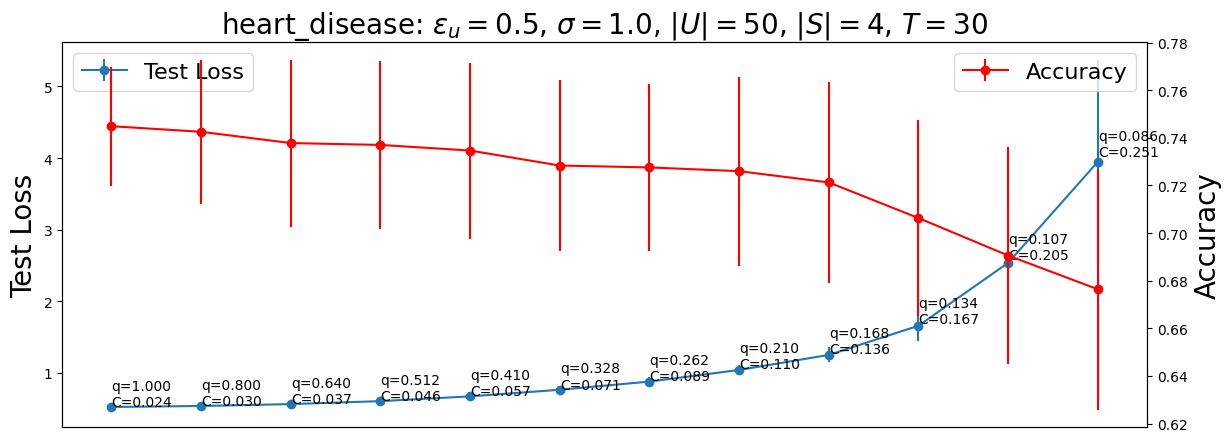

01/03/2024 20:01:18:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


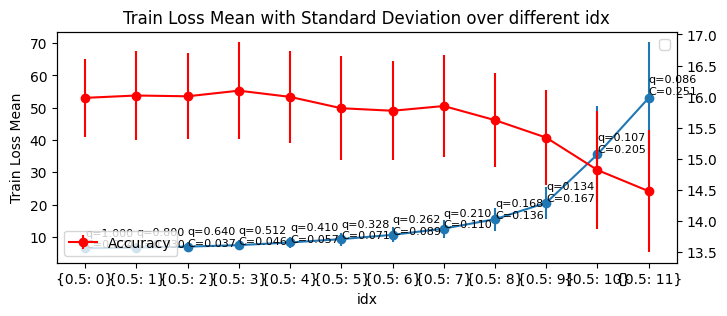

{0.5: 0} 0.5248098134994507


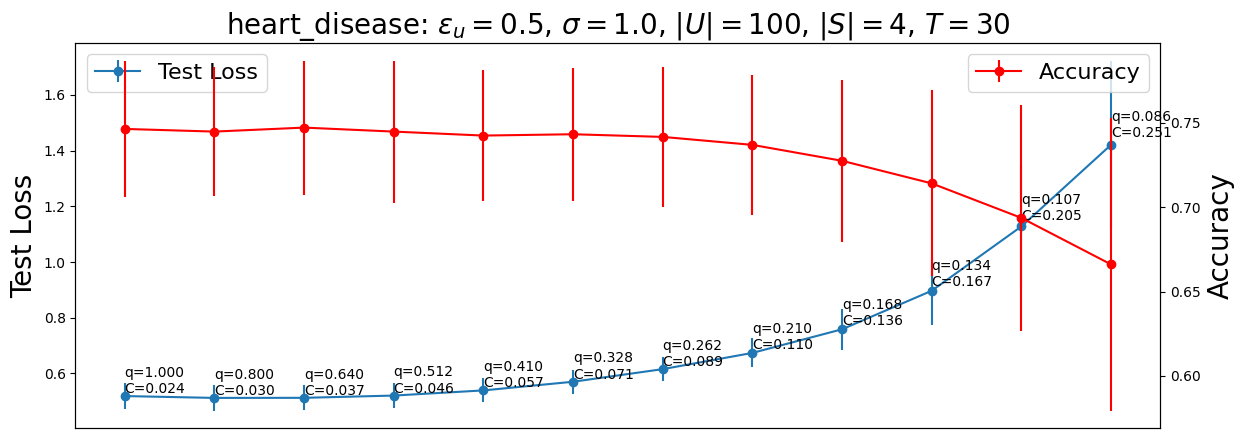

01/03/2024 20:01:19:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


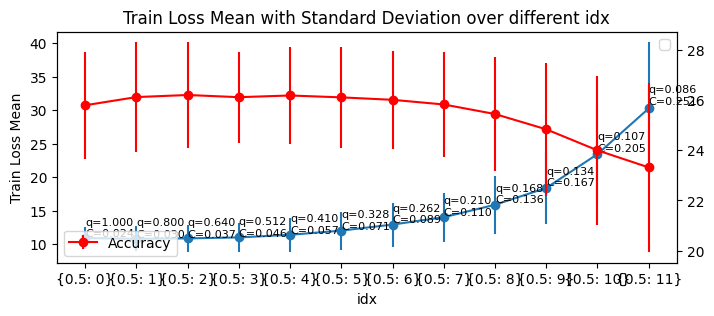

{0.5: 1} 0.5122230529785157


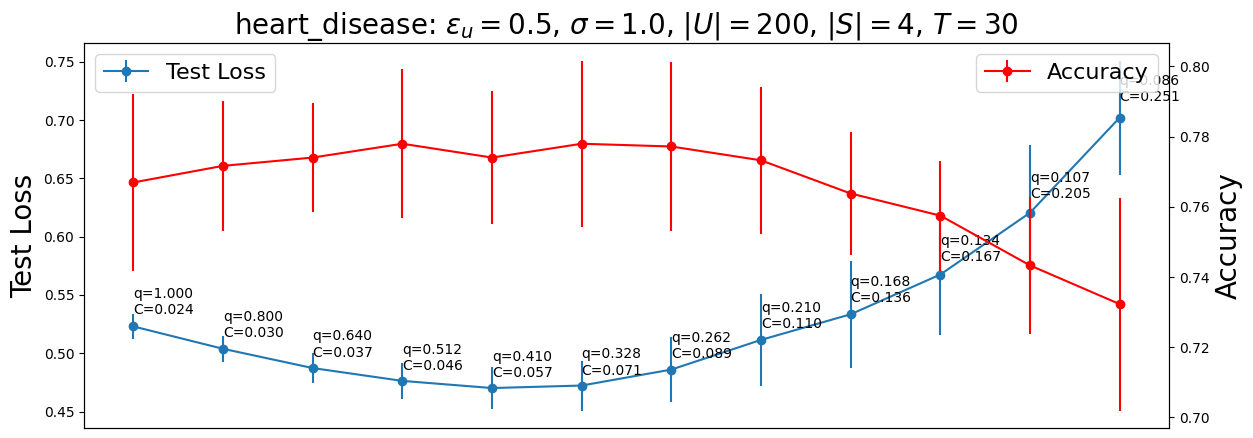

01/03/2024 20:01:19:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


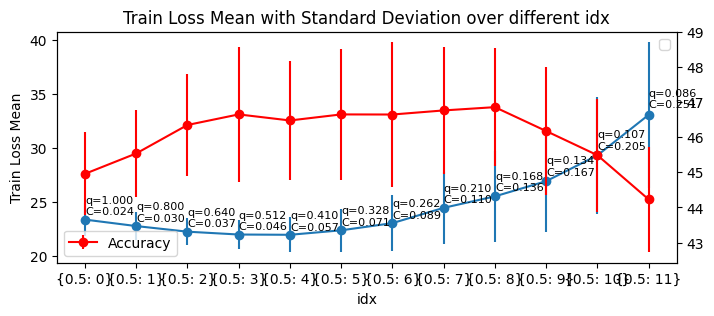

{0.5: 4} 0.47016355991363523


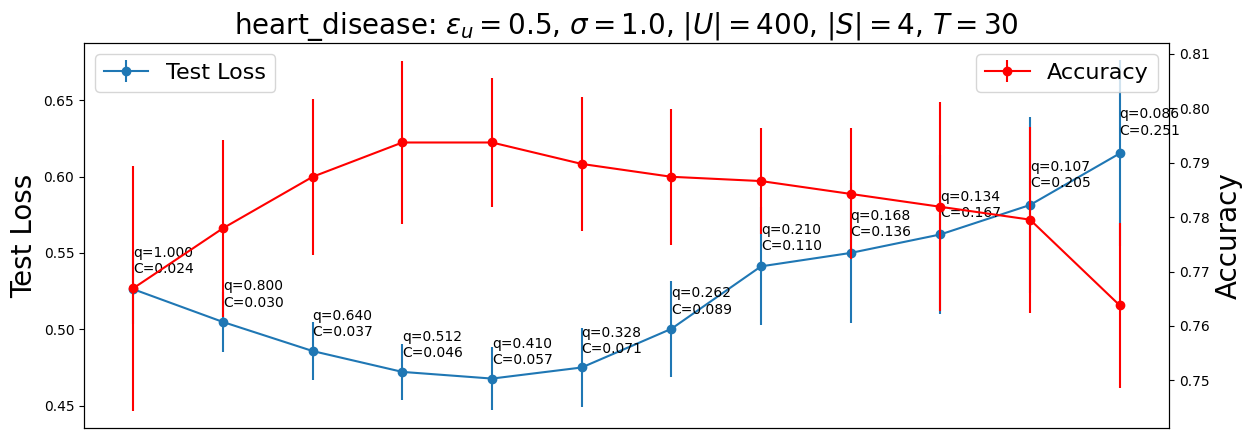

01/03/2024 20:01:20:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


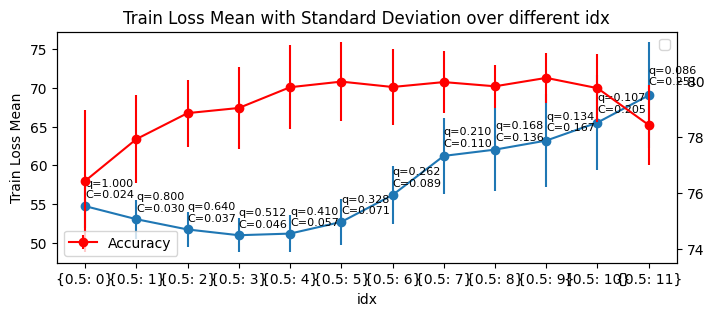

{0.5: 4} 0.46767913103103637


In [ ]:
sigma = 1.0
epsilon_list = [0.5]
group_thresholds = [0.5]
ratio_list = [1.0]
delta = 1e-5
n_round = 30
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 5
validation_ratio = 0.0

for n_users in [50, 100, 200, 400]:
    random_state = np.random.RandomState(0)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

    logger_set_warning()
    # static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy=opt_strategy, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30, validation_ratio=validation_ratio)
    min_idx, min_loss = show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, n_silos=4, opt_strategy=opt_strategy, validation_ratio=validation_ratio, train_loss=True, img_name=f"heart_disease-users-{n_users}")
    print(min_idx, min_loss)

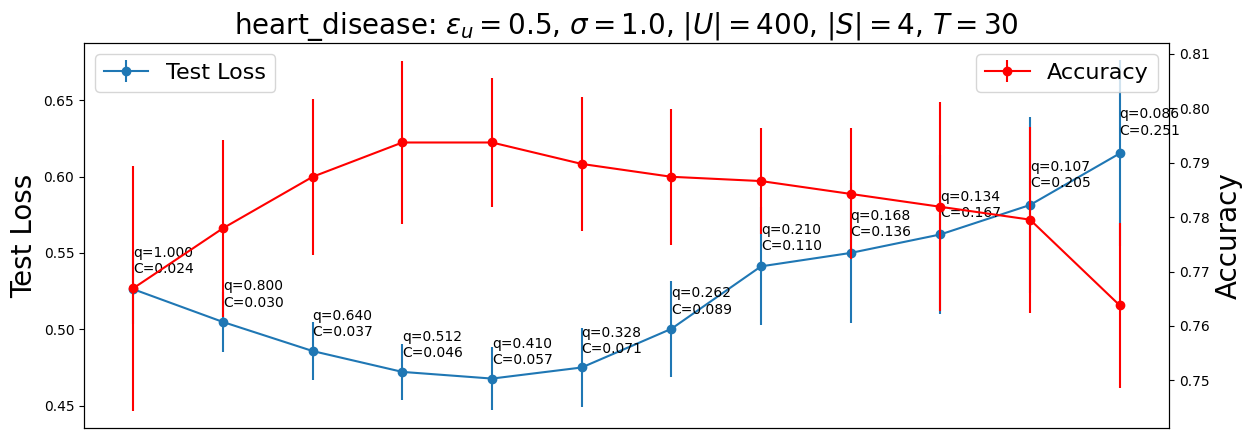

01/03/2024 20:51:18:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


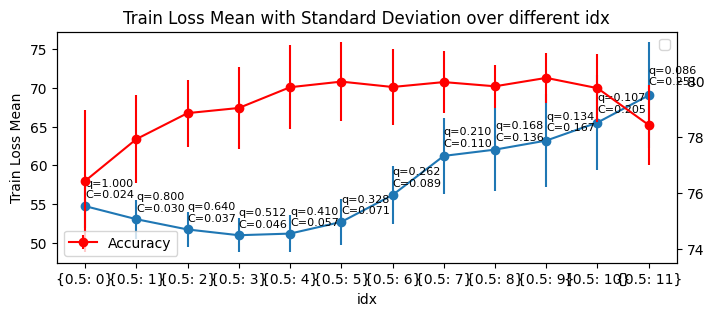

{0.5: 4} 0.46767913103103637


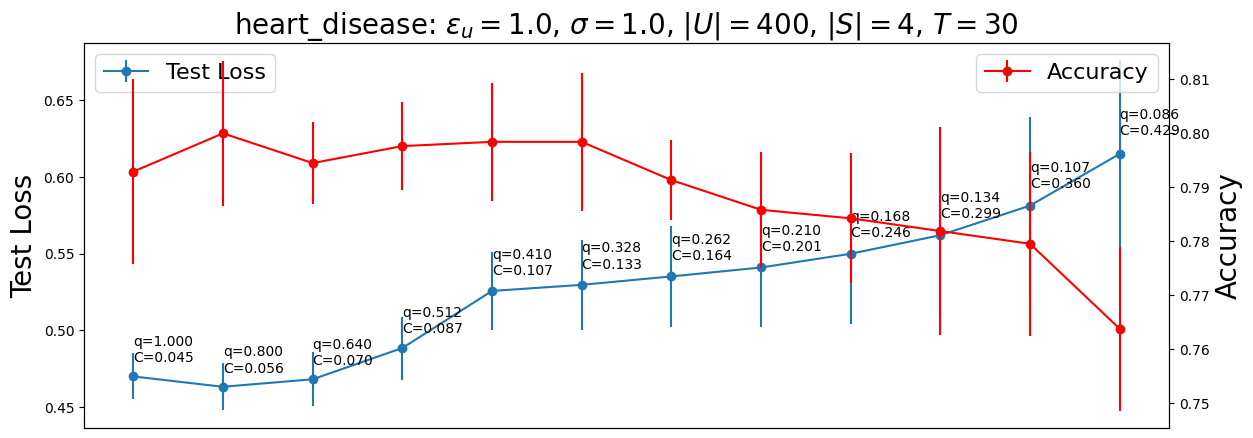

01/03/2024 20:51:18:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


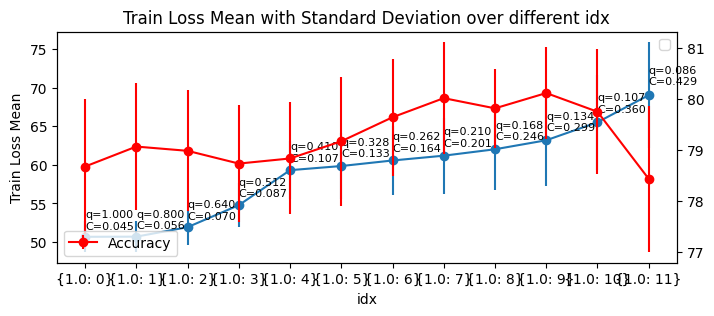

{1.0: 1} 0.46323083639144896


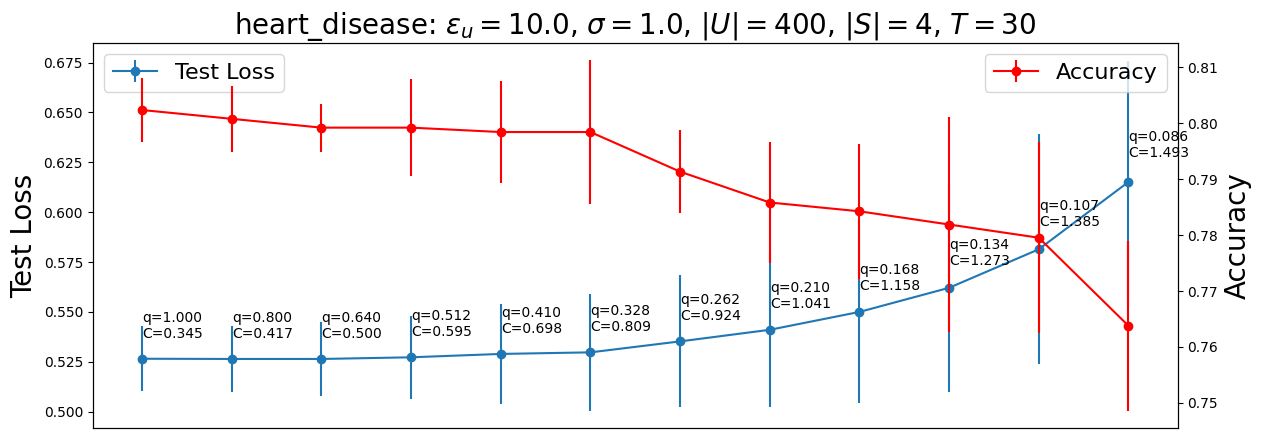

01/03/2024 20:51:19:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


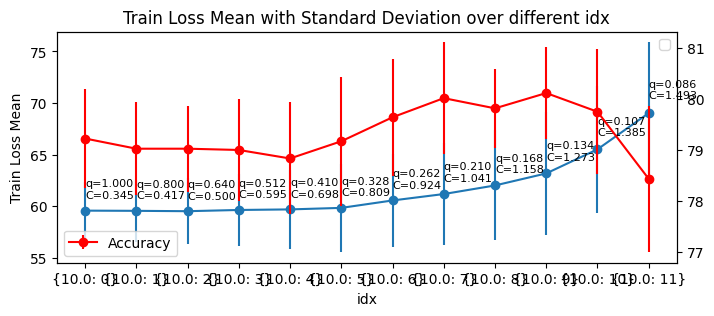

{10.0: 2} 0.5264011502265931


In [ ]:
sigma = 1.0
ratio_list = [1.0]
delta = 1e-5
n_round = 30
n_users = 400
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 5
validation_ratio = 0.0

for eps_u in [0.5, 1.0, 10.0]:
    epsilon_list = [eps_u]
    group_thresholds = [eps_u]
    random_state = np.random.RandomState(0)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

    logger_set_warning()
    # static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy=opt_strategy, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30, validation_ratio=validation_ratio)
    min_idx, min_loss = show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, n_silos=4, opt_strategy=opt_strategy, validation_ratio=validation_ratio, train_loss=True, img_name=f"heart_disease-eps-{epsilon_list[0]}")
    print(min_idx, min_loss)

### tcga brca

In [ ]:
sigma = 1.0
epsilon_list = [1.0]
group_thresholds = [1.0]
ratio_list = [1.0]
delta = 1e-5
n_users = 100
n_round = 1
dataset_name = 'tcga_brca'
q_step_size = 0.8
times = 5

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

logger_set_warning()
static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy=opt_strategy, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50, validation_ratio=0.9)
min_idx, min_loss = show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, opt_strategy=opt_strategy, validation_ratio=0.9)
print(min_idx, min_loss)

In [ ]:
sigma = 1.0
epsilon_list = [1.0]
group_thresholds = [1.0]
ratio_list = [1.0]
delta = 1e-5
n_users = 130
n_round = 30
dataset_name = 'tcga_brca'
q_step_size = 0.8
times = 5

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy=opt_strategy, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50, validation_ratio=0.9)
min_idx, min_loss = show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, opt_strategy=opt_strategy, validation_ratio=0.9, train_loss=True)
print(min_idx, min_loss)

### body

In [ ]:
sigma = 0.5
epsilon_list = [3.0]
group_thresholds = [3.0]
ratio_list = [1.0]
delta = 1e-5
n_users = 500
n_round = 50
dataset_name = 'body'
q_step_size = 0.8
times = 5
validation_ratio = 0.8

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=16)

logger_set_warning()
# static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy=opt_strategy, global_learning_rate=5.0, local_learning_rate=0.001, local_epochs=30, validation_ratio=validation_ratio)
min_idx, min_loss = show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, n_silos=5, opt_strategy=opt_strategy, validation_ratio=validation_ratio, train_loss=True, img_name="body")
print(min_idx, min_loss)

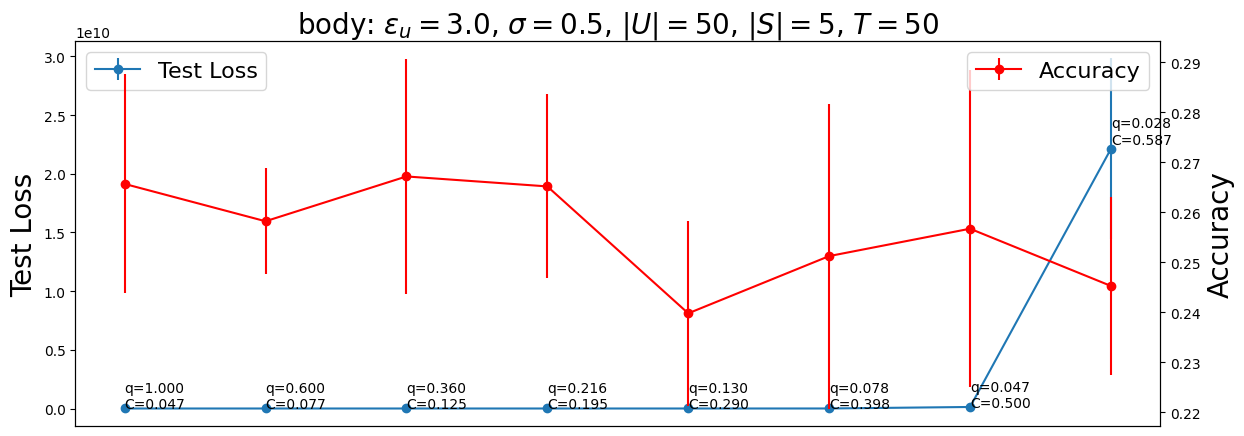

01/06/2024 11:23:08:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


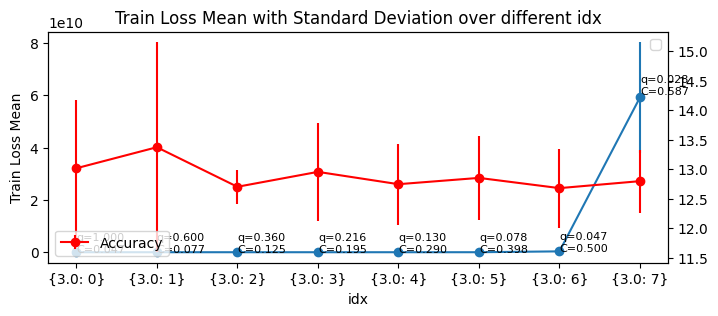

01/06/2024 11:23:09:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


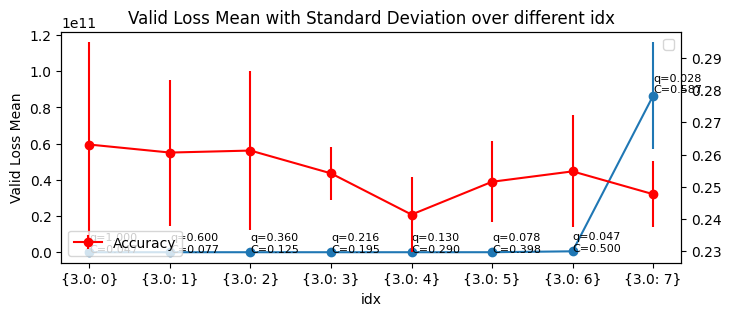

{3.0: 0} 1.4415141344070435


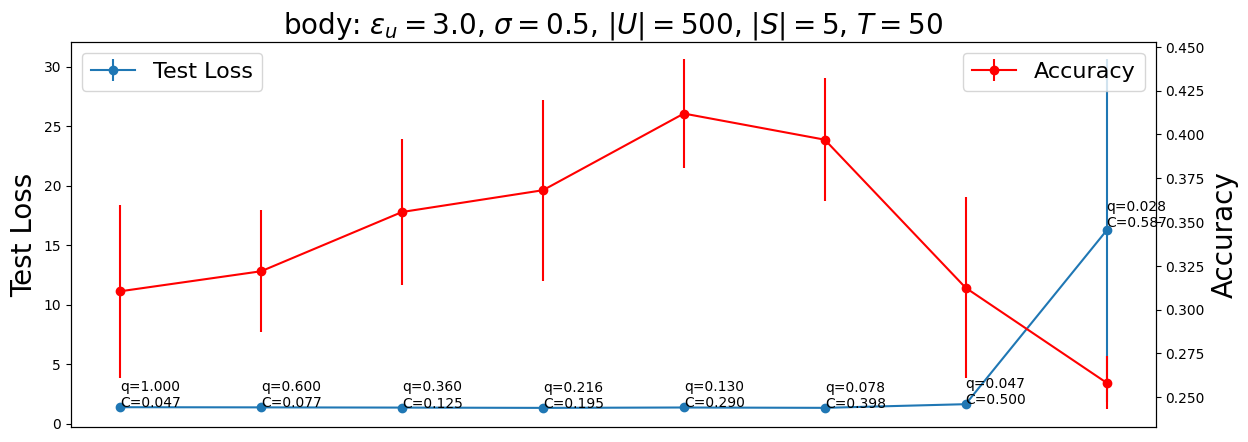

01/06/2024 11:23:09:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


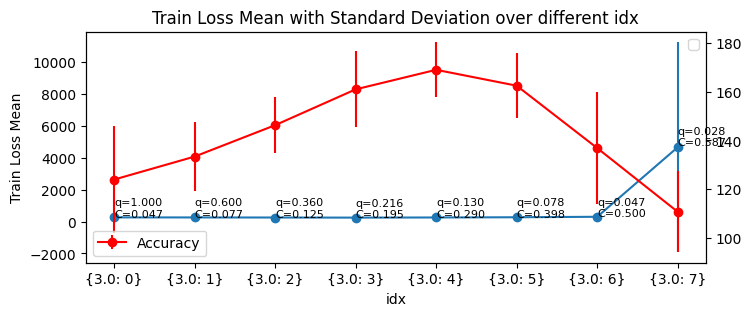

01/06/2024 11:23:09:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


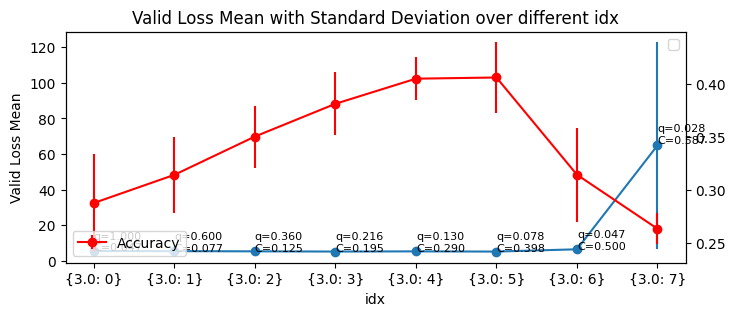

{3.0: 3} 1.3126425266265869


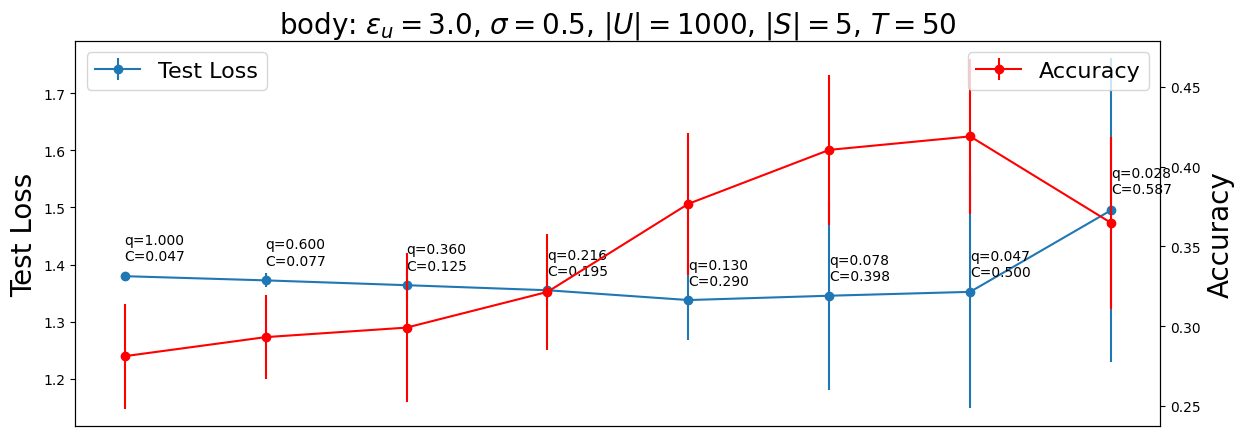

01/06/2024 11:23:10:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


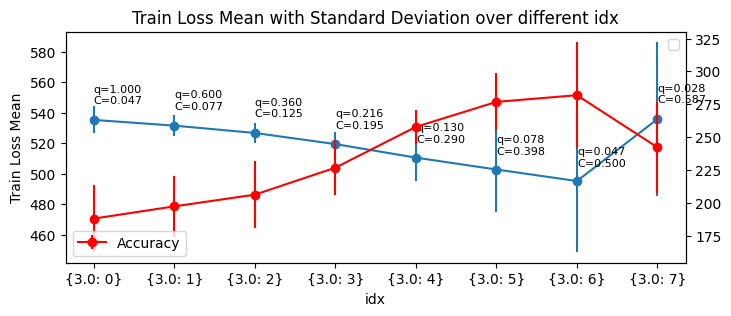

01/06/2024 11:23:10:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


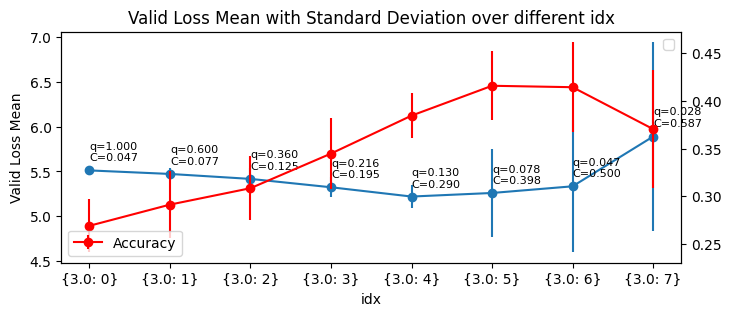

{3.0: 4} 1.3378304958343505


In [ ]:
sigma = 0.5
epsilon_list = [3.0]
group_thresholds = [3.0]
ratio_list = [1.0]
delta = 1e-5
n_users = 500
n_round = 50
dataset_name = 'body'
q_step_size = 0.6
times = 5
validation_ratio = 0.8

for n_users in [50, 500, 1000]:
    random_state = np.random.RandomState(0)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=8)

    logger_set_warning()
    # static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy=opt_strategy, global_learning_rate=5.0, local_learning_rate=0.001, local_epochs=30, validation_ratio=validation_ratio)
    min_idx, min_loss = show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, n_silos=5, opt_strategy=opt_strategy, validation_ratio=validation_ratio, train_loss=True, img_name=f"{dataset_name}-users-{n_users}")
    print(min_idx, min_loss)

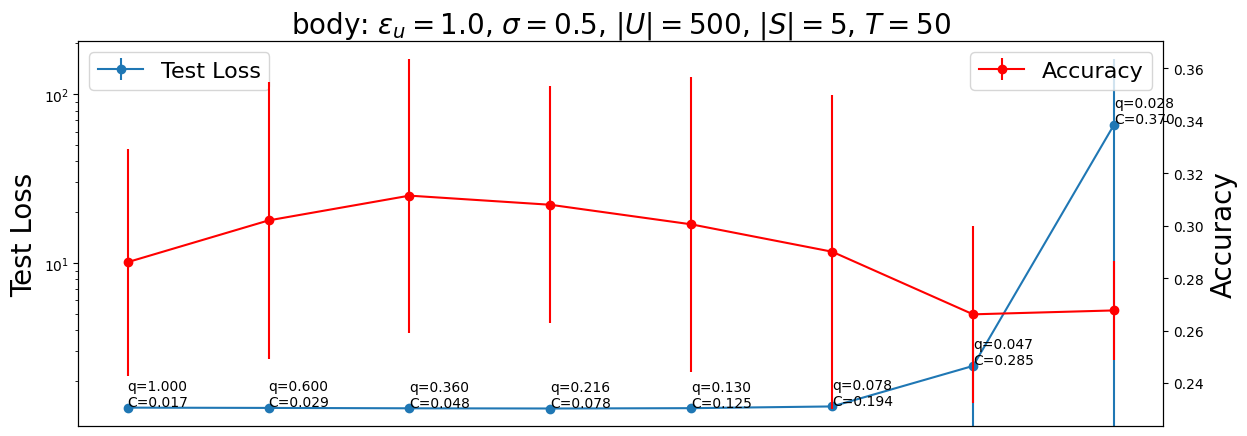

01/06/2024 22:49:03:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


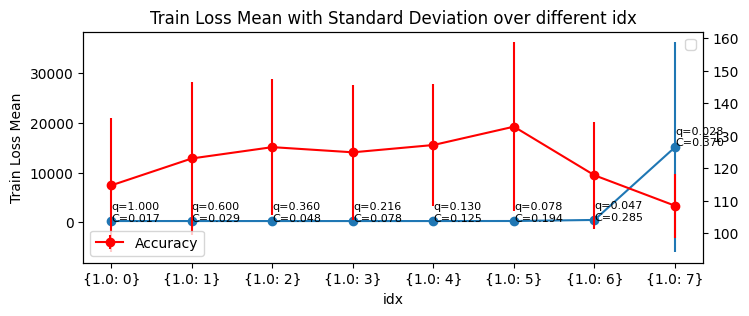

01/06/2024 22:49:03:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


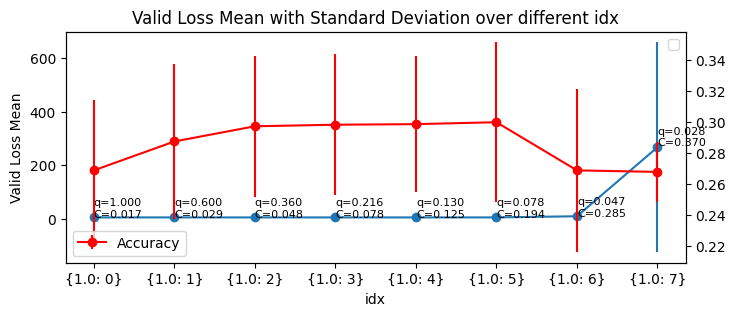

{1.0: 3} 1.3681272268295288


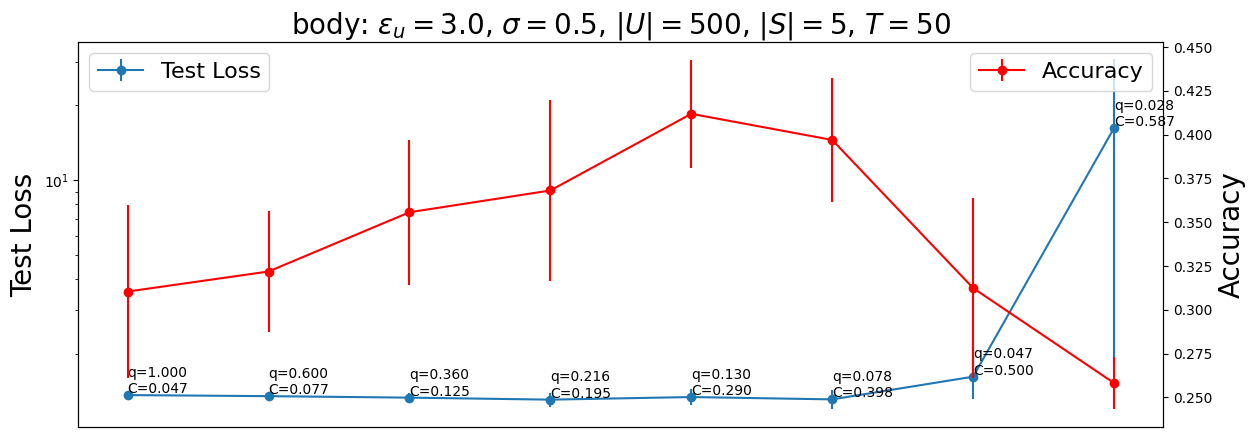

01/06/2024 22:49:04:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


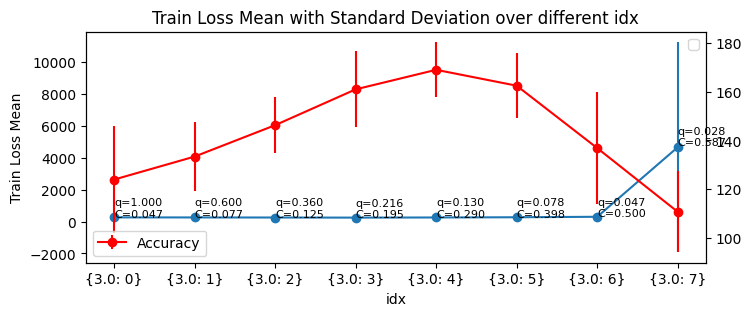

01/06/2024 22:49:04:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


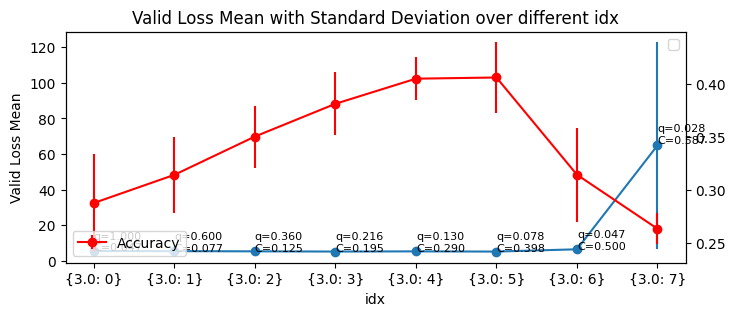

{3.0: 3} 1.3126425266265869


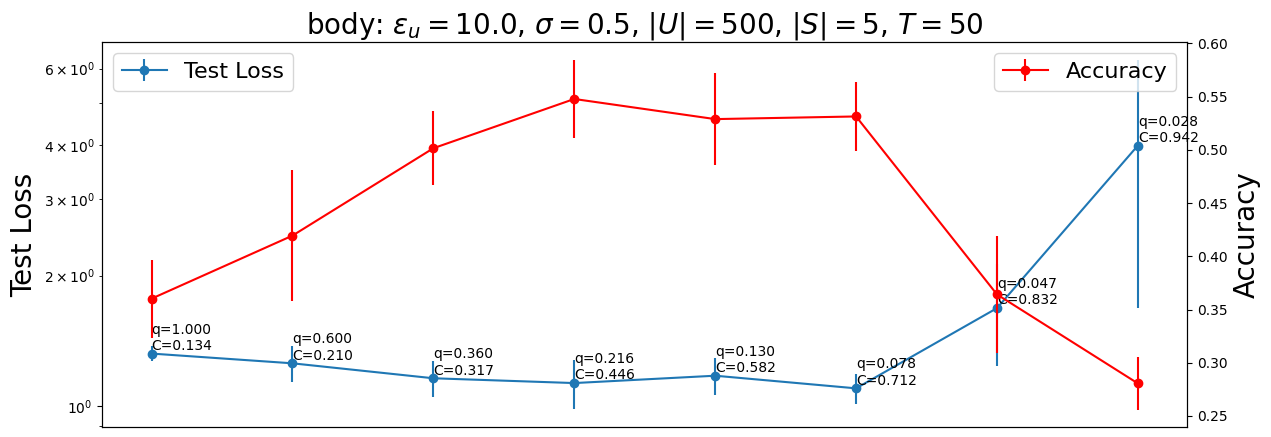

01/06/2024 22:49:04:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


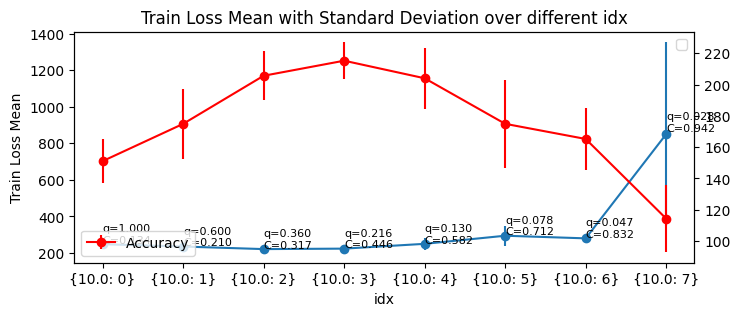

01/06/2024 22:49:05:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


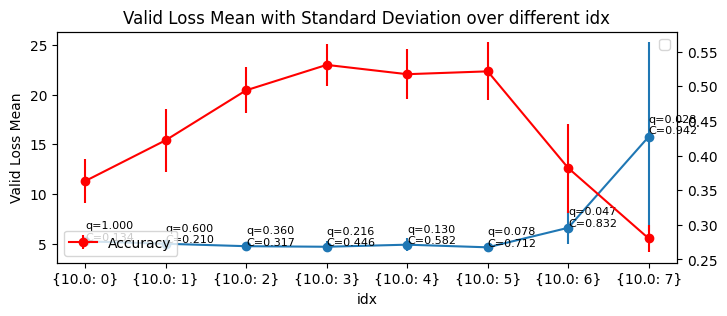

{10.0: 5} 1.0995294332504273


In [ ]:
sigma = 0.5
ratio_list = [1.0]
delta = 1e-5
n_users = 500
n_round = 50
dataset_name = 'body'
q_step_size = 0.6
times = 5
validation_ratio = 0.8

for eps_u in [1.0, 3.0, 10.0]:
    epsilon_list = [eps_u]
    group_thresholds = [eps_u]
    random_state = np.random.RandomState(0)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=8)

    logger_set_warning()
    # static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy=opt_strategy, global_learning_rate=5.0, local_learning_rate=0.001, local_epochs=30, validation_ratio=validation_ratio)
    min_idx, min_loss = show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, n_silos=5, opt_strategy=opt_strategy, validation_ratio=validation_ratio, train_loss=True, img_name=f"body-eps-{epsilon_list[0]}")
    print(min_idx, min_loss)

### creditcard

In [ ]:
sigma = 1.0
epsilon_list = [3.0]
group_thresholds = [3.0]
ratio_list = [1.0]
delta = 1e-5
n_users = 2000
n_round = 20
dataset_name = 'creditcard'
q_step_size = 0.8
times = 3
validation_ratio = 0.8

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=8)

logger_set_warning()
static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy=opt_strategy, global_learning_rate=20.0, local_learning_rate=0.001, local_epochs=20, validation_ratio=validation_ratio)
min_idx, min_loss = show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, opt_strategy=opt_strategy, validation_ratio=validation_ratio, train_loss=True)
print(min_idx, min_loss)

In [ ]:
sigma = 0.5
epsilon_list = [5.0]
group_thresholds = [5.0]
ratio_list = [1.0]
delta = 1e-5
n_users = 1000
n_round = 30
dataset_name = 'creditcard'
q_step_size=0.8
times = 5

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy=opt_strategy, global_learning_rate=10.0, local_learning_rate=0.01, local_epochs=30, validation_ratio=0.5)
min_idx, min_loss = show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, opt_strategy=opt_strategy, validation_ratio=0.9, train_loss=True)


### run with specified (best) idx

In [ ]:
n_users = 300
sigma = 1.0
epsilon_list = [3.0]
group_thresholds = [3.0]
ratio_list = [1.0]
delta = 1e-5
dataset_name = 'heart_disease'
n_round=30
idx_per_group = {3.0: 4}
q_step_size = 0.8
times = 5

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

run_with_specified_idx(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, times, idx_per_group, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50, validation_ratio=0.9)


In [ ]:
n_users = 100
sigma = 0.5
epsilon_list = [3.0]
group_thresholds = [3.0]
ratio_list = [1.0]
delta = 1e-5
dataset_name = 'tcga_brca'
n_round = 30
idx_per_group = {3.0: 2}
q_step_size = 0.8
times = 5

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

run_with_specified_idx(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, times, idx_per_group, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50, validation_ratio=0.9)


## Single Epsilon group

#### Online optimization with Test Loss 
- share two kinds of parameter delta

In [ ]:
# heart disease with different delta
n_users_list = [300]
sigma = 1.0
epsilon_list = [5.0]
group_thresholds = [5.0]
ratio_list = [1.0]
delta = 1e-5
n_round = 40
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online" # with Test Loss, assuming Test dataset
with_momentum = True
train_loss_dp = False
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None

prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)
    show_online_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


#### Online optimization with Raw Train Loss
- share raw train loss without DP

In [ ]:
# heart disease with different delta
n_users_list = [300]
sigma = 1.0
epsilon_list = [5.0]
group_thresholds = [5.0]
ratio_list = [1.0]
delta = 1e-5
n_round = 40
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = False
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)
    show_online_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


#### Online optimization with user-level DP metric
- share approximated train loss with user-level DP metric

In [ ]:
n_users_list = [300]
sigma = 1.0
epsilon_list = [3.0]
group_thresholds = [3.0]
ratio_list = [1.0]
delta = 1e-5
n_round = 40
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = False
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = False
hp_baseline = "random"


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
        local_epochs=50, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline,)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)

In [ ]:
n_users_list = [300]
sigma = 1.0
epsilon_list = [3.0]
group_thresholds = [3.0]
ratio_list = [1.0]
delta = 1e-5
n_round = 40
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = False
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = False
hp_baseline = "random-updown"


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
        local_epochs=50, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline,)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)

In [ ]:
n_users_list = [300]
sigma = 1.0
epsilon_list = [5.0]
group_thresholds = [5.0]
ratio_list = [1.0]
delta = 1e-5
n_round = 40
dataset_name = 'heart_disease'
q_step_size = 0.8
validation_ratio = 0.0
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = True
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None

logger_set_info()

prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
        local_epochs=50, validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline,)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


In [ ]:
n_users_list = [300]
sigma = 1.0
epsilon_list = [5.0]
group_thresholds = [5.0]
ratio_list = [1.0]
delta = 1e-5
n_round = 40
dataset_name = 'heart_disease'
q_step_size = 0.8
validation_ratio = 0.0
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = True
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None

logger_set_info()

prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=5.0, local_learning_rate=0.001, 
        local_epochs=50, validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline,)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


In [ ]:
n_users_list = [300]
sigma = 1.0
epsilon_list = [5.0]
group_thresholds = [5.0]
ratio_list = [1.0]
delta = 1e-5
n_round = 40
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 10
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = True
sigma_for_online_optimization = 5.0
total_dp_eps_for_online_optimization = False


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
        local_epochs=50, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


## Multiple Epsilon groups

#### with DP train metric

##### heart disease

In [ ]:
# heart disease with different delta
n_users_list = [400]
sigma = 1.0
epsilon_list = [1.0, 3.0, 5.0]
group_thresholds = epsilon_list
ratio_list = [0.34, 0.43, 0.23]
delta = 1e-5
n_round = 20
dataset_name = 'heart_disease'
q_step_size = 0.8
validation_ratio = 0.0
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = True
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
        local_epochs=50, validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline, errorbar=False, img_name=f"{dataset_name}-users-{n_users}")

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)

n_users: 300
======== TIME: 0 start
[17:23:35 INFO] Start federated learning simulation
[17:23:44 INFO] |----- Global test result of round 0
[17:23:44 INFO] 	 |----- Test/Acc: 0.6535433070866141 (254), Test/Loss: 0.6653474569320679
[17:23:44 INFO] eps_u: 1.0, original loss_diff: -20.87511390700316, (self.momentum[eps_u]: -20.87511390700316)
[17:23:44 INFO] eps_u: 3.0, original loss_diff: -15.070499660113079, (self.momentum[eps_u]: -15.070499660113079)
[17:23:44 INFO] eps_u: 5.0, original loss_diff: 12.295405079536259, (self.momentum[eps_u]: 12.295405079536259)
[17:23:44 INFO] Next HP: (Q_u, C_u) = {1.0: (0.8, 0.03980463370680809), 3.0: (0.8, 0.10741837322711945), 5.0: (1.0, 0.13551749289035797)}
[17:23:44 INFO] 

========== end 0-th round training ===========

[17:23:52 INFO] |----- Global test result of round 1
[17:23:52 INFO] 	 |----- Test/Acc: 0.6811023622047244 (254), Test/Loss: 0.6423884034156799
[17:23:52 INFO] eps_u: 1.0, original loss_diff: 4.47661647047795, (self.momentum[eps_

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[17:24:34 INFO] |----- Global test result of round 9
[17:24:34 INFO] 	 |----- Test/Acc: 0.7913385826771654 (254), Test/Loss: 0.4715755879878998
[17:24:34 INFO] eps_u: 1.0, original loss_diff: 23.696157129505657, (self.momentum[eps_u]: 15.99891399167974)
[17:24:34 INFO] eps_u: 3.0, original loss_diff: -8.265502754034372, (self.momentum[eps_u]: -3.686009381222969)
[17:24:34 INFO] eps_u: 5.0, original loss_diff: -21.4798388861603, (self.momentum[eps_u]: 1.6132505766891772)
[17:24:34 INFO] Next HP: (Q_u, C_u) = {1.0: (0.5769198706700285, 0.05496121011674404), 3.0: (0.18452514066426332, 0.411280058324337), 5.0: (1.0, 0.13551749289035797)}
[17:24:34 INFO] 

========== end 9-th round training ===========

[17:24:38 INFO] |----- Global test result of round 10
[17:24:38 INFO] 	 |----- Test/Acc: 0.7992125984251969 (254), Test/Loss: 0.46180835366249084
[17:24:38 INFO] eps_u: 1.0, original loss_diff: 27.64886347684739, (self.momentum[eps_u]: 18.328903888713267)
[17:24:38 INFO] eps_u: 3.0, original

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[17:26:54 INFO] |----- Global test result of round 10
[17:26:54 INFO] 	 |----- Test/Acc: 0.7480314960629921 (254), Test/Loss: 0.5162443518638611
[17:26:54 INFO] eps_u: 1.0, original loss_diff: 73.60935556931835, (self.momentum[eps_u]: -6.014213072582006)
[17:26:54 INFO] eps_u: 3.0, original loss_diff: -25.605099504347184, (self.momentum[eps_u]: -10.335332476733255)
[17:26:54 INFO] eps_u: 5.0, original loss_diff: 3.5705613959121285, (self.momentum[eps_u]: 3.51230400214372)
[17:26:54 INFO] Next HP: (Q_u, C_u) = {1.0: (0.3418475709545046, 0.0917455181479454), 3.0: (0.5273912160000002, 0.16027227975428104), 5.0: (0.8310751842328754, 0.16179869417101145)}
[17:26:54 INFO] 

========== end 10-th round training ===========

[17:26:59 INFO] |----- Global test result of round 11
[17:26:59 INFO] 	 |----- Test/Acc: 0.7519685039370079 (254), Test/Loss: 0.5077651739120483
[17:26:59 INFO] eps_u: 1.0, original loss_diff: 13.774522670953031, (self.momentum[eps_u]: -2.0564659238749994)
[17:26:59 INFO] e

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[17:28:48 INFO] |----- Global test result of round 6
[17:28:48 INFO] 	 |----- Test/Acc: 0.7401574803149606 (254), Test/Loss: 0.545781135559082
[17:28:48 INFO] eps_u: 1.0, original loss_diff: 29.59528620997197, (self.momentum[eps_u]: -7.989503859973405)
[17:28:48 INFO] eps_u: 3.0, original loss_diff: -10.112283869479914, (self.momentum[eps_u]: -7.834495712725422)
[17:28:48 INFO] eps_u: 5.0, original loss_diff: -17.52015918471656, (self.momentum[eps_u]: -3.2196292958959445)
[17:28:48 INFO] Next HP: (Q_u, C_u) = {1.0: (0.41791562400000015, 0.07541975937783718), 3.0: (0.7310000000000002, 0.11721393093466759), 5.0: (0.8600000000000001, 0.15660282224416733)}
[17:28:48 INFO] 

========== end 6-th round training ===========

[17:28:54 INFO] |----- Global test result of round 7
[17:28:54 INFO] 	 |----- Test/Acc: 0.7716535433070866 (254), Test/Loss: 0.5246980786323547
[17:28:54 INFO] eps_u: 1.0, original loss_diff: 51.45447985806187, (self.momentum[eps_u]: 3.899292883633647)
[17:28:54 INFO] eps_

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[17:31:06 INFO] |----- Global test result of round 7
[17:31:06 INFO] 	 |----- Test/Acc: 0.7952755905511811 (254), Test/Loss: 0.5057077407836914
[17:31:06 INFO] eps_u: 1.0, original loss_diff: -4.563016041142276, (self.momentum[eps_u]: -19.312257564099955)
[17:31:06 INFO] eps_u: 3.0, original loss_diff: 0.29504881774947833, (self.momentum[eps_u]: 1.4753306795832246)
[17:31:06 INFO] eps_u: 5.0, original loss_diff: -1.2492280609856579, (self.momentum[eps_u]: 0.20131232159073464)
[17:31:06 INFO] Next HP: (Q_u, C_u) = {1.0: (0.2356041121862402, 0.13142284005880356), 3.0: (1.0, 0.08645786438137293), 5.0: (0.8663271047069638, 0.15551014803349972)}
[17:31:06 INFO] 

========== end 7-th round training ===========

[17:31:13 INFO] |----- Global test result of round 8
[17:31:13 INFO] 	 |----- Test/Acc: 0.7952755905511811 (254), Test/Loss: 0.4964112937450409
[17:31:13 INFO] eps_u: 1.0, original loss_diff: 15.573277211175299, (self.momentum[eps_u]: -12.335150609044906)
[17:31:13 INFO] eps_u: 3.0, o

KeyboardInterrupt: 

n_users: 300


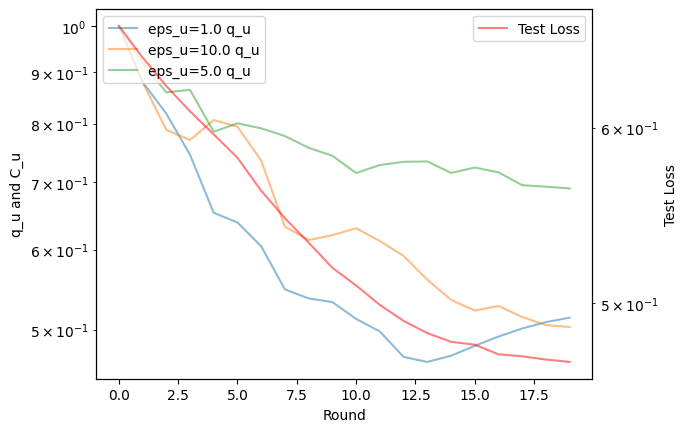

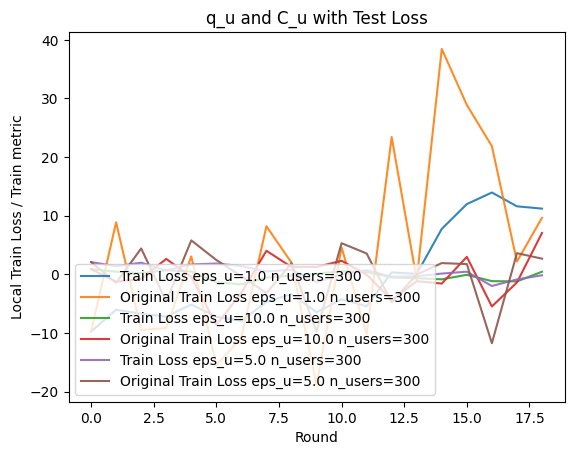

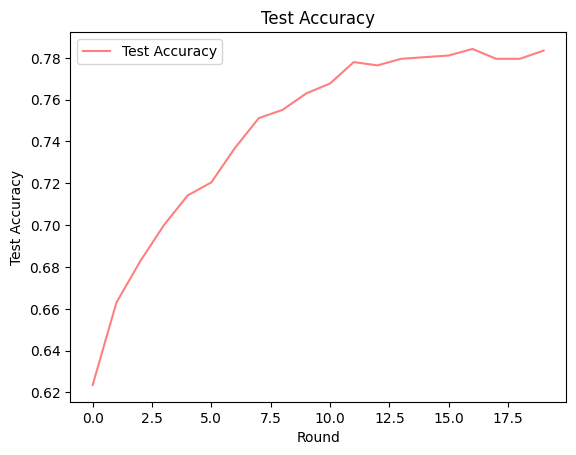

In [ ]:
# heart disease with different delta
n_users_list = [300]
sigma = 1.0
epsilon_list = [1.0, 3.0, 5.0]
group_thresholds = epsilon_list
ratio_list = [0.8, 0.1, 0.1]
delta = 1e-5
n_round = 20
dataset_name = 'heart_disease'
q_step_size = 0.8
validation_ratio = 0.0
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = True
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    # run_online_optimization(
    #     epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
    #     group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
    #     local_epochs=50, validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
    #     train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
    #     total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline, errorbar=False)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


n_users: 300


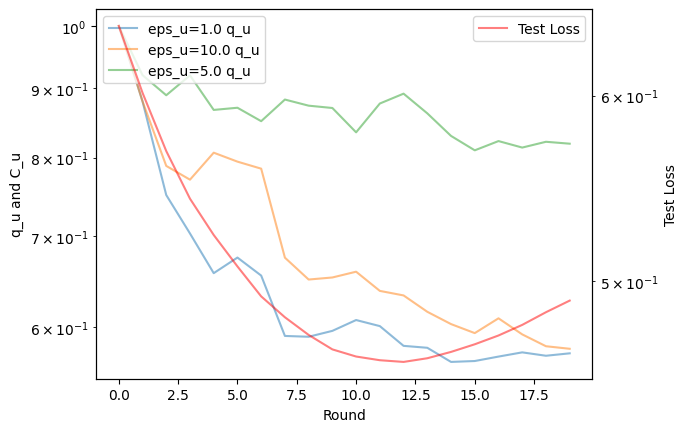

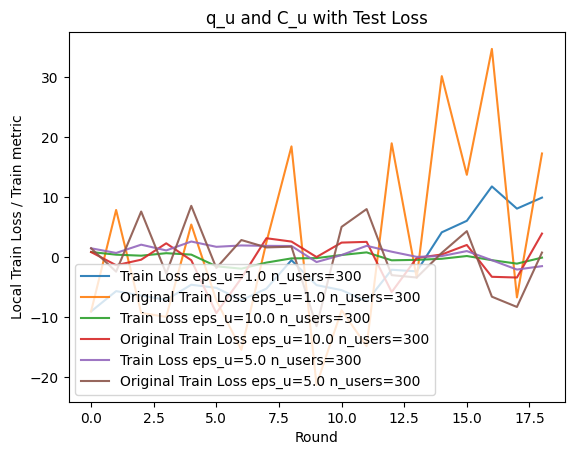

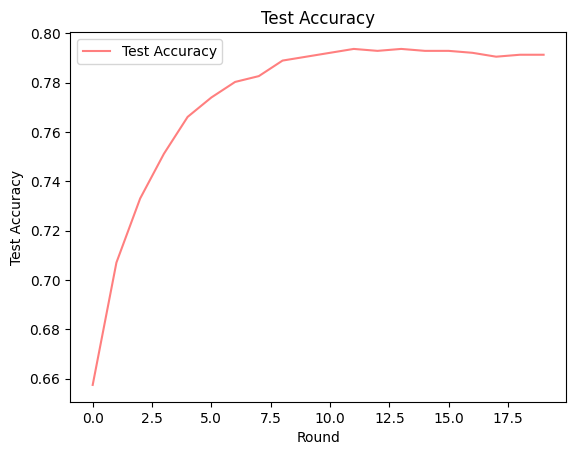

In [ ]:
# heart disease with different delta
n_users_list = [300]
sigma = 1.0
epsilon_list = [1.0, 5.0, 10.0]
group_thresholds = epsilon_list
ratio_list = [0.1, 0.8, 0.1]
delta = 1e-5
n_round = 20
dataset_name = 'heart_disease'
q_step_size = 0.8
validation_ratio = 0.0
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = True
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    # run_online_optimization(
    #     epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
    #     group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
    #     local_epochs=50, validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
    #     train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
    #     total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline, errorbar=False)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


n_users: 300
======== TIME: 0 start
[10:36:24 INFO] Start federated learning simulation
[10:36:33 INFO] |----- Global test result of round 0
[10:36:33 INFO] 	 |----- Test/Acc: 0.5984251968503937 (254), Test/Loss: 0.6838687658309937
[10:36:33 INFO] eps_u: 1.0, original loss_diff: -23.645947240336483, (self.momentum[eps_u]: -23.645947240336483)
[10:36:33 INFO] Next HP: (Q_u, C_u) = {1.0: (0.8, 0.03980463370680809)}
[10:36:33 INFO] 

========== end 0-th round training ===========

[10:36:40 INFO] |----- Global test result of round 1
[10:36:40 INFO] 	 |----- Test/Acc: 0.6141732283464567 (254), Test/Loss: 0.6741233468055725
[10:36:40 INFO] eps_u: 1.0, original loss_diff: 60.818030288315455, (self.momentum[eps_u]: -6.753151734606099)
[10:36:40 INFO] Next HP: (Q_u, C_u) = {1.0: (0.6480000000000001, 0.04901518113911152)}
[10:36:40 INFO] 

========== end 1-th round training ===========

[10:36:46 INFO] |----- Global test result of round 2
[10:36:46 INFO] 	 |----- Test/Acc: 0.6338582677165354 (2

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[10:37:29 INFO] |----- Global test result of round 18
[10:37:29 INFO] 	 |----- Test/Acc: 0.7992125984251969 (254), Test/Loss: 0.45180344581604004
[10:37:29 INFO] eps_u: 1.0, original loss_diff: -63.40301786180957, (self.momentum[eps_u]: 12.105399755346612)
[10:37:29 INFO] Next HP: (Q_u, C_u) = {1.0: (0.18956079680182486, 0.16163848340511322)}
[10:37:29 INFO] 

========== end 18-th round training ===========

[10:37:31 INFO] |----- Global test result of round 19
[10:37:31 INFO] 	 |----- Test/Acc: 0.7874015748031497 (254), Test/Loss: 0.4598139822483063
[10:37:31 INFO] eps_u: 1.0, original loss_diff: -23.426670879913242, (self.momentum[eps_u]: 4.998985628294643)
[10:37:31 INFO] Next HP: (Q_u, C_u) = {1.0: (0.19147555232507563, 0.16010962426662445)}
[10:37:31 INFO] 

========== end 19-th round training ===========

[10:37:33 INFO] Final epsilon for 1.0 is 0.999672408765981 (including eps_u)
[10:37:33 INFO] Finish federated learning simulation
======== TIME: 1 start
[10:37:33 INFO] Start fe

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[10:38:36 INFO] |----- Global test result of round 17
[10:38:36 INFO] 	 |----- Test/Acc: 0.7598425196850394 (254), Test/Loss: 0.530613899230957
[10:38:36 INFO] eps_u: 1.0, original loss_diff: -21.18566511280967, (self.momentum[eps_u]: -12.016888029761294)
[10:38:36 INFO] Next HP: (Q_u, C_u) = {1.0: (0.14205814641950018, 0.21164696663618088)}
[10:38:36 INFO] 

========== end 17-th round training ===========

[10:38:37 INFO] |----- Global test result of round 18
[10:38:37 INFO] 	 |----- Test/Acc: 0.7637795275590551 (254), Test/Loss: 0.5415908098220825
[10:38:37 INFO] eps_u: 1.0, original loss_diff: 25.9049476820975, (self.momentum[eps_u]: -4.432520887389536)
[10:38:37 INFO] Next HP: (Q_u, C_u) = {1.0: (0.13921698349111017, 0.21562296897172928)}
[10:38:37 INFO] 

========== end 18-th round training ===========

[10:38:38 INFO] |----- Global test result of round 19
[10:38:38 INFO] 	 |----- Test/Acc: 0.7480314960629921 (254), Test/Loss: 0.5538331270217896
[10:38:38 INFO] eps_u: 1.0, origina

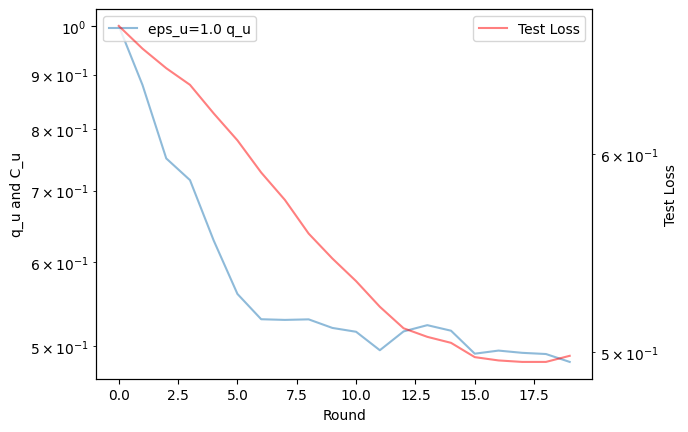

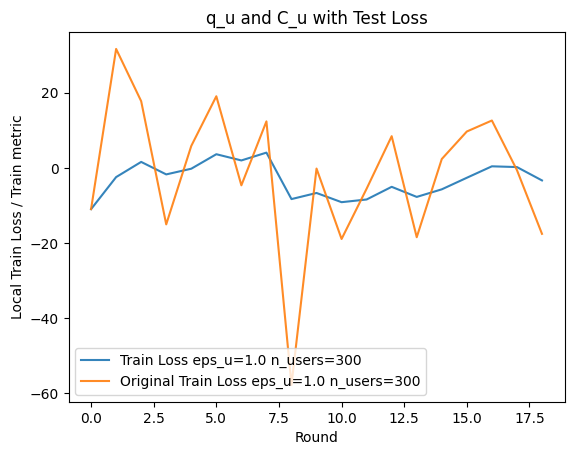

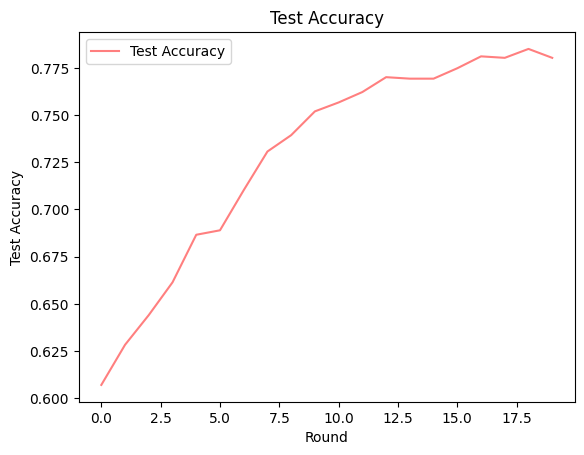

In [ ]:
# heart disease with different delta
n_users_list = [300]
sigma = 1.0
epsilon_list = [1.0]
group_thresholds = epsilon_list
ratio_list = [1.0]
delta = 1e-5
n_round = 20
dataset_name = 'heart_disease'
q_step_size = 0.8
validation_ratio = 0.0
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = True
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
        local_epochs=50, validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline, errorbar=False)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


In [ ]:
# heart disease with different delta
n_users_list = [300]
sigma = 1.0
epsilon_list = [1.0, 5.0, 10.0]
group_thresholds = epsilon_list
ratio_list = [0.3, 0.4, 0.3]
delta = 1e-5
n_round = 20
dataset_name = 'heart_disease'
q_step_size = 0.8
validation_ratio = 0.0
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = True
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
        local_epochs=50, validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline, errorbar=False)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


n_users: 300
======== TIME: 0 start
[15:56:43 INFO] Start federated learning simulation
[15:56:52 INFO] |----- Global test result of round 0
[15:56:52 INFO] 	 |----- Test/Acc: 0.6535433070866141 (127), Test/Loss: 0.6607099771499634
[15:56:52 INFO] |----- Global valid result of round 0
[15:56:52 INFO] 	 |----- Test/Acc: 0.6929133858267716 (127), Test/Loss: 0.6440967321395874
[15:56:52 INFO] eps_u = 1.0, diff = -0.0028352737426757812
[15:56:52 INFO] eps_u = 10.0, diff = 0.01026618480682373
[15:56:52 INFO] eps_u = 5.0, diff = 0.036859989166259766
[15:56:52 INFO] eps_u: 1.0, original loss_diff: -0.0028352737426757812, (self.momentum[eps_u]: -0.0028352737426757812)
[15:56:52 INFO] eps_u: 10.0, original loss_diff: 0.01026618480682373, (self.momentum[eps_u]: 0.01026618480682373)
[15:56:52 INFO] eps_u: 5.0, original loss_diff: 0.036859989166259766, (self.momentum[eps_u]: 0.036859989166259766)
[15:56:52 INFO] Next HP: (Q_u, C_u) = {1.0: (0.8, 0.03980463370680809), 10.0: (1.0, 0.2437686198391020

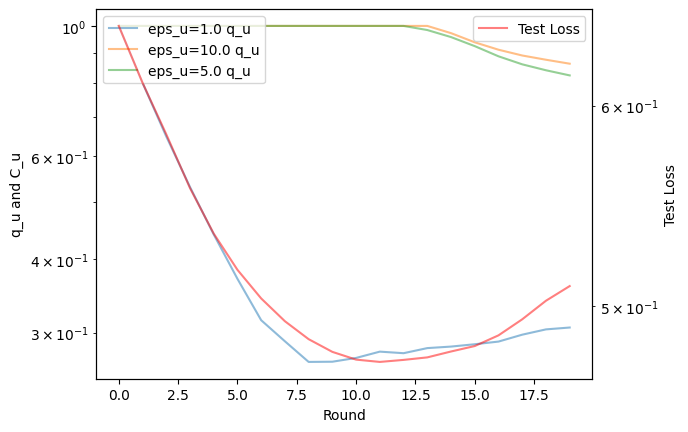

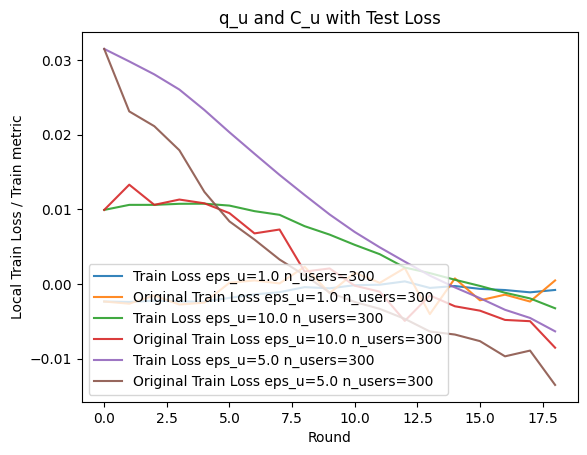

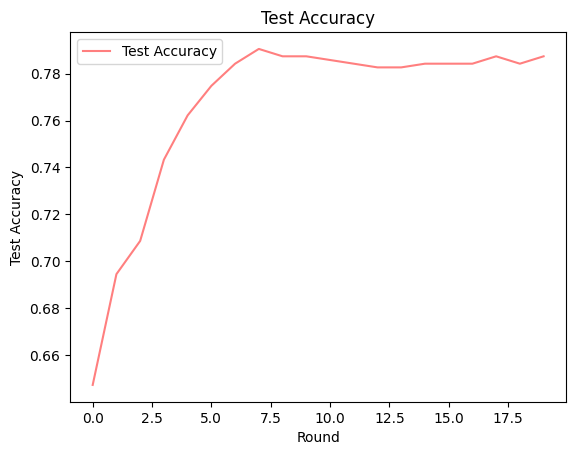

In [ ]:
# heart disease with different delta
n_users_list = [300]
sigma = 1.0
epsilon_list = [1.0, 5.0, 10.0]
group_thresholds = epsilon_list
ratio_list = [0.3, 0.4, 0.3]
delta = 1e-5
n_round = 20
dataset_name = 'heart_disease'
q_step_size = 0.8
validation_ratio = 0.5
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online"
with_momentum = True
train_loss_dp = False
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
        local_epochs=50, validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline, errorbar=False)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


##### Body

In [ ]:
n_users_list = [1000]
sigma = 0.5
epsilon_list = [1.0, 5.0, 10.0]
group_thresholds = epsilon_list
ratio_list = [0.3, 0.4, 0.3]
delta = 1e-5
n_round = 50
dataset_name = 'body'
q_step_size = 0.8
validation_ratio = 0.0
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = True
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline, errorbar=False)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


n_users: 1000
======== TIME: 0 start
[16:19:19 INFO] Start federated learning simulation
[16:23:42 INFO] |----- Global test result of round 0
[16:23:42 INFO] 	 |----- Test/Acc: 0.2498755599800896 (2009), Test/Loss: 5.606738328933716
[16:23:42 INFO] eps_u: 1.0, original loss_diff: 8.294214467871052, (self.momentum[eps_u]: 8.294214467871052)
[16:23:42 INFO] eps_u: 10.0, original loss_diff: -2.494629611113952, (self.momentum[eps_u]: -2.494629611113952)
[16:23:42 INFO] eps_u: 5.0, original loss_diff: 1.070057542874851, (self.momentum[eps_u]: 1.070057542874851)
[16:23:42 INFO] Next HP: (Q_u, C_u) = {1.0: (1.0, 0.010091695003211498), 10.0: (0.8, 0.09565622312948108), 5.0: (1.0, 0.04285439499653876)}
[16:23:42 INFO] 

========== end 0-th round training ===========

[16:27:53 INFO] |----- Global test result of round 1
[16:27:53 INFO] 	 |----- Test/Acc: 0.2498755599800896 (2009), Test/Loss: 5.60096287727356
[16:27:53 INFO] eps_u: 1.0, original loss_diff: -49.06612800167258, (self.momentum[eps_u

KeyboardInterrupt: 

##### creditcard - test

In [ ]:
# heart disease with different delta
n_users_list = [2000]
sigma = 1.0
epsilon_list = [1.0, 5.0, 10.0]
group_thresholds = epsilon_list
ratio_list = [0.3, 0.4, 0.3]
delta = 1e-5
n_round = 40
dataset_name = 'creditcard'
q_step_size = 0.8
validation_ratio = 0.8
times = 2
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online"
with_momentum = True
train_loss_dp = False
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None

logger_set_warning()

prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.01, 
        local_epochs=50, validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline, errorbar=False)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


##### creditcard - train

In [ ]:
# heart disease with different delta
n_users_list = [2000]
sigma = 1.0
epsilon_list = [1.0, 5.0, 10.0]
group_thresholds = epsilon_list
ratio_list = [0.3, 0.4, 0.3]
delta = 1e-5
n_round = 40
dataset_name = 'creditcard'
q_step_size = 0.8
validation_ratio = 0.0
times = 2
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = True
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.01, 
        local_epochs=50, validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline, errorbar=False)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


#### online optimization with Test loss

In [ ]:
# heart disease with different delta
n_users_list = [2000]
sigma = 1.0
epsilon_list = [1.0, 5.0, 10.0]
group_thresholds = epsilon_list
ratio_list = [0.3, 0.4, 0.3]
delta = 1e-5
n_round = 40
dataset_name = 'creditcard'
q_step_size = 0.8
validation_ratio = 0.8
times = 2
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online"
with_momentum = True
train_loss_dp = True
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.01, 
        local_epochs=50, validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline, errorbar=False)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


#### online optimization with non-DP train-loss


In [ ]:
# heart disease with different delta
n_users_list = [300]
sigma = 1.0
epsilon_list = [1.0, 5.0, 10.0]
group_thresholds = epsilon_list
ratio_list = [0.3, 0.4, 0.3]
delta = 1e-5
n_round = 40
dataset_name = 'heart_disease'
q_step_size = 0.95
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = False
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = False
hp_baseline = None

prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)
    show_online_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


## EXP 6.1

01/09/2024 21:40:55:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{0.15: 1, 1.0: 1, 5.0: 1}


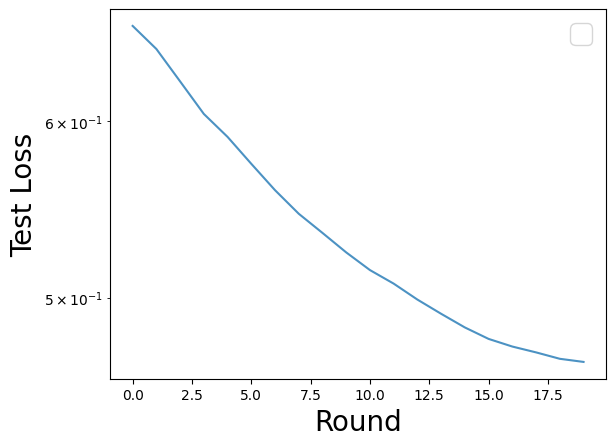

01/09/2024 21:40:55:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{0.15: 9}


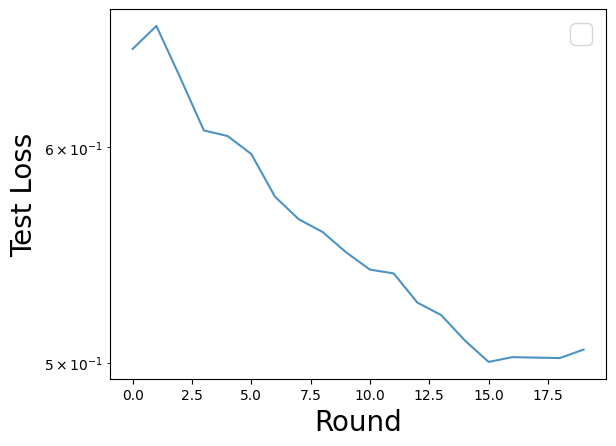

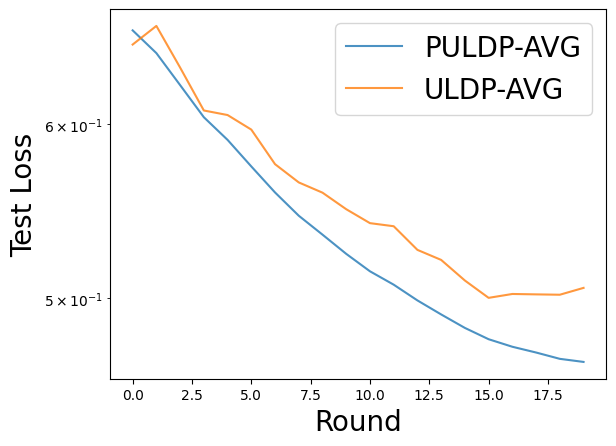

In [103]:
logger_set_warning()

conservative_eps = 0.15
normal_eps = 1.0
liberal_eps = 5.0

n_users = 400
sigma = 1.0
epsilon_list = [conservative_eps, normal_eps, liberal_eps]
group_thresholds = epsilon_list
ratio_list = [0.34, 0.43, 0.23]
delta = 1e-5
n_round = 20
dataset_name = 'heart_disease'
q_step_size = 0.8
validation_ratio = 0.0
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG"
with_momentum = False
train_loss_dp = False
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = False
hp_baseline = None

prefix_epsilon_u_list = []
idx_per_group_list = []

for i in [1]:
    for j in [1]:
        for k in [1]:
            idx_per_group = {conservative_eps: i, normal_eps: j, liberal_eps: k}
            idx_per_group_list.append(idx_per_group)
            print(idx_per_group)
            epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
            grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
            epsilon_u = {}
            for eps_u, user_ids in grouped.items():
                for user_id in user_ids:
                    epsilon_u[user_id] = eps_u
            prefix_epsilon_u = list(epsilon_u.items())[:4]
            prefix_epsilon_u_list.append(prefix_epsilon_u)
            # run_with_specified_idx(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, times, 
            #     idx_per_group=idx_per_group,  global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50)
            show_specified_idx_result(prefix_epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, idx_per_group, validation_ratio=validation_ratio, img_name=f"{dataset_name}-puldlpavg", errorbar=False)


epsilon_list = [conservative_eps]
group_thresholds = epsilon_list
ratio_list = [1.0]

for i in [9]:
    idx_per_group = {conservative_eps: i}
    idx_per_group_list.append(idx_per_group)
    print(idx_per_group)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    prefix_epsilon_u = list(epsilon_u.items())[:4]
    prefix_epsilon_u_list.append(prefix_epsilon_u)
    # run_with_specified_idx(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, times, 
    #     idx_per_group=idx_per_group,  global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50)
    show_specified_idx_result(prefix_epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, idx_per_group, validation_ratio=validation_ratio, img_name=f"{dataset_name}-uldlpavg", errorbar=False)

show_specified_idx_result(prefix_epsilon_u_list, sigma, delta, n_users, n_round, dataset_name, q_step_size, idx_per_group_list, label_list=["PULDP-AVG", "ULDP-AVG"], validation_ratio=validation_ratio, img_name=f"{dataset_name}-comparison", errorbar=False)


In [ ]:
n_users_list = [500]
sigma = 0.5
epsilon_list = [1.0, 3.0, 5.0]
group_thresholds = epsilon_list
ratio_list = [0.34, 0.43, 0.23]
delta = 1e-5
n_round = 50
dataset_name = 'body'
q_step_size = 0.8
validation_ratio = 0.0
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG"
with_momentum = False
train_loss_dp = False
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = False
hp_baseline = None

idx_per_group = {1.0: 5, 3.0: 5, 5.0: 5}

prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_with_specified_idx(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, times, 
        idx_per_group=idx_per_group,  global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50)
    prefix_epsilon_u = list(epsilon_u.items())[:4]
    show_specified_idx_result(prefix_epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, idx_per_group=idx_per_group, validation_ratio=validation_ratio, img_name=f"{dataset_name}-puldpavg")


n_users_list = [500]
sigma = 0.5
epsilon_list = [1.0, 3.0, 5.0]
group_thresholds = epsilon_list
ratio_list = [0.34, 0.43, 0.23]
delta = 1e-5
n_round = 50
dataset_name = 'body'
q_step_size = 0.8
validation_ratio = 0.0
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG"
with_momentum = False
train_loss_dp = False
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = False
hp_baseline = None

idx_per_group = {1.0: 10}

prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_with_specified_idx(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, times, 
        idx_per_group=idx_per_group,  global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50)
    prefix_epsilon_u = list(epsilon_u.items())[:4]
    show_specified_idx_result(prefix_epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, idx_per_group=idx_per_group, validation_ratio=validation_ratio, img_name=f"{dataset_name}-uldpavg")


## EXP 6.2

In [ ]:
# heart disease with different delta
n_users_list = [400]
sigma = 1.0
epsilon_list = [1.0, 3.0, 5.0]
group_thresholds = epsilon_list
ratio_list = [0.34, 0.43, 0.23]
delta = 1e-5
n_round = 20
dataset_name = 'heart_disease'
q_step_size = 0.8
validation_ratio = 0.0
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = True
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True
hp_baseline = None


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
        local_epochs=50, validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization, hp_baseline=hp_baseline, errorbar=False, img_name=f"{dataset_name}-users-{n_users}")

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)